<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_5_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Addapted from the [book](https://https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main)

This code defines two functions:

1. `sample_batch(dataset)`:
   - Takes a `dataset` object as input.
   - Retrieves a single batch from the dataset using `dataset.take(1).get_single_element()`.
   - If the batch is a tuple, it extracts the first element of the tuple.
   - Returns the batch as a NumPy array using `batch.numpy()`.

2. `display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None)`:
   - Takes an array of `images` and optional parameters for display configuration.
   - Normalizes the pixel values of the images to the range [0, 1] if the maximum value is greater than 1.0, or to the range [-1, 1] if the minimum value is less than 0.0.
   - Creates a figure with a specified size using `plt.figure(figsize=size)`.
   - Iterates over `n` random images from the `images` array.
   - Displays each image as a subplot using `plt.subplot(1, n, i + 1)` and `plt.imshow()`.
   - Applies the specified colormap (`cmap`) and data type (`as_type`) to the displayed images.
   - Removes the axis labels and ticks using `plt.axis("off")`.
   - If `save_to` is provided, saves the figure to the specified file path and prints a message.
   - Finally, shows the plotted images using `plt.show()`.


In [ ]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [ ]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

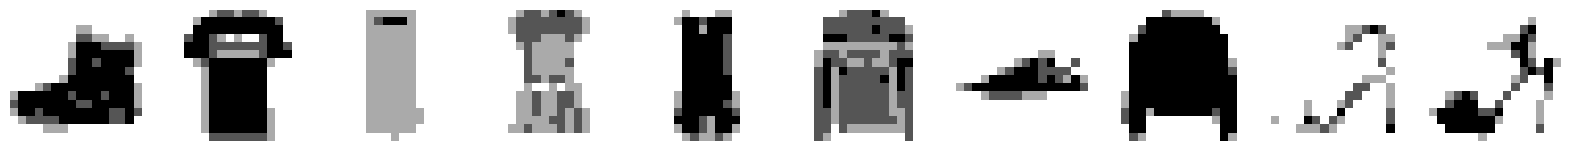

In [ ]:
# Show some items of clothing from the training set
display(input_data)

The code in the following cell defines a custom layer called `MaskedConv2D` which extends the functionality of the standard 2D convolutional layer (`layers.Conv2D`) by including masking.



1. The `MaskedConv2D` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `mask_type` parameter and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(MaskedConv2D, self).__init__()`) and initializes the `mask_type` attribute. It also creates an instance of `layers.Conv2D` with the provided `**kwargs` and assigns it to the `conv` attribute.

3. The `build` method is called when the layer is being built. It first builds the `conv` layer to initialize its kernel variables. Then, it retrieves the shape of the kernel using `self.conv.kernel.get_shape()` and creates a mask tensor (`self.mask`) with the same shape, initialized with zeros.

4. Depending on the `mask_type`, the mask is populated with ones in specific regions:
   - For the upper half of the kernel (excluding the center row), the mask values are set to 1.0.
   - For the left half of the center row (including the center pixel), the mask values are set to 1.0.
   - If the `mask_type` is "B", the center pixel of the kernel is also set to 1.0.

5. The `call` method is invoked when the layer is called with an input tensor. It multiplies the `conv` layer's kernel with the mask using element-wise multiplication (`self.conv.kernel * self.mask`). This effectively applies the mask to the kernel, zeroing out the desired regions. Then, it calls the `conv` layer with the masked kernel and returns the output.

6. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `MaskedConv2D` layer is to apply a mask to the convolutional kernel, allowing only certain regions of the kernel to be active during the convolution operation. This is particularly useful in architectures like PixelCNN, where the masking ensures that each pixel in the output depends only on the pixels above and to the left of it in the input, following a specific order.

In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code in the following cell defines a custom layer called `ResidualBlock` which implements a residual block architecture commonly used in deep neural networks. Residual blocks allow the network to learn residual functions and facilitate the training of deep networks by alleviating the vanishing gradient problem.


1. The `ResidualBlock` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `filters` parameter, which determines the number of filters in the convolutional layers, and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(ResidualBlock, self).__init__(**kwargs)`).

3. Inside the constructor, three convolutional layers are defined:
   - `self.conv1`: A standard 2D convolutional layer (`layers.Conv2D`) with `filters // 2` filters (half the input filters), kernel size of 1, and ReLU activation.
   - `self.pixel_conv`: An instance of the `MaskedConv2D` layer (defined in the previous code snippet) with mask type "B", `filters // 2` filters (half the input filters), kernel size of 3, ReLU activation, and "same" padding.
   - `self.conv2`: Another standard 2D convolutional layer with `filters` filters (same as the input filters), kernel size of 1, and ReLU activation.

4. The `call` method is invoked when the layer is called with an input tensor. It defines the forward pass of the residual block:
   - The input tensor is passed through `self.conv1`, followed by `self.pixel_conv`, and then `self.conv2`.
   - The output of `self.conv2` is added element-wise to the original input tensor using `layers.add([inputs, x])`, creating the residual connection.
   - The result of the element-wise addition is returned as the output of the residual block.

5. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `ResidualBlock` is to learn residual functions by allowing the network to pass information from the input directly to the output through the residual connection. The block consists of two branches:
- The main branch applies a series of convolutional operations (conv1 → pixel_conv → conv2) to the input.
- The residual branch simply passes the input directly to the output.

The outputs of both branches are then added element-wise, enabling the network to learn the residual function. This residual connection helps in training deep networks by allowing the gradients to flow more easily through the network, mitigating the vanishing gradient problem.

The `MaskedConv2D` layer used in the `pixel_conv` ensures that the convolution operation follows a specific masking pattern, which is useful in a PixelCNN.

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code below defines the architecture of a PixelCNN model using the Keras functional API.

1. `inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))`:
   - This line defines the input layer of the model using `layers.Input`.
   - The input shape is specified as `(IMAGE_SIZE, IMAGE_SIZE, 1)`, indicating that the input images have a height and width of `IMAGE_SIZE` and a single channel (grayscale).

2. `x = MaskedConv2D(mask_type="A", filters=N_FILTERS, kernel_size=7, activation="relu", padding="same")(inputs)`:
   - The input tensor is passed through a `MaskedConv2D` layer with mask type "A", `N_FILTERS` filters, a kernel size of 7, ReLU activation, and "same" padding.
   - This layer applies a masked convolution operation to the input, allowing the model to capture local dependencies.

3. `for _ in range(RESIDUAL_BLOCKS): x = ResidualBlock(filters=N_FILTERS)(x)`:
   - This loop creates a stack of `RESIDUAL_BLOCKS` residual blocks.
   - Each residual block is created using the `ResidualBlock` layer defined in the previous code snippet, with `N_FILTERS` filters.
   - The output of each residual block is assigned back to `x`, forming a deep residual network.

4. `for _ in range(2): x = MaskedConv2D(mask_type="B", filters=N_FILTERS, kernel_size=1, strides=1, activation="relu", padding="valid")(x)`:
   - This loop applies two additional `MaskedConv2D` layers with mask type "B", `N_FILTERS` filters, a kernel size of 1, stride of 1, ReLU activation, and "valid" padding.
   - These layers further process the output of the residual blocks.

5. `out = layers.Conv2D(filters=PIXEL_LEVELS, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)`:
   - The final layer is a standard 2D convolutional layer (`layers.Conv2D`) with `PIXEL_LEVELS` filters, a kernel size of 1, stride of 1, softmax activation, and "valid" padding.
   - This layer produces the output of the model, representing the probability distribution over the pixel values.

6. `pixel_cnn = models.Model(inputs, out)`:
   - The `pixel_cnn` model is created using `models.Model`, specifying the input tensor (`inputs`) and the output tensor (`out`).
   - This defines the complete PixelCNN model architecture.

7. `pixel_cnn.summary()`:
   - This line prints a summary of the PixelCNN model architecture, displaying the layers, their output shapes, and the number of parameters in each layer.

The resulting `pixel_cnn` model is a deep convolutional neural network that learns to generate images pixel by pixel. The architecture consists of a stack of masked convolutional layers and residual blocks, which capture the dependencies between pixels and allow the model to generate coherent and realistic images.

The use of masked convolutions ensures that the model follows a specific order in generating pixels, where each pixel depends only on the pixels above and to the left of it in the image.

In [ ]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

In [ ]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="/content/images/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [ ]:
!mkdir ./images

mkdir: cannot create directory ‘./images’: File exists


Epoch 1/150
  6/469 [..............................] - ETA: 5s - loss: 0.3937 

465/469 [============================>.] - ETA: 0s - loss: 0.3890
Saved to /content/images/generated_img_000.png


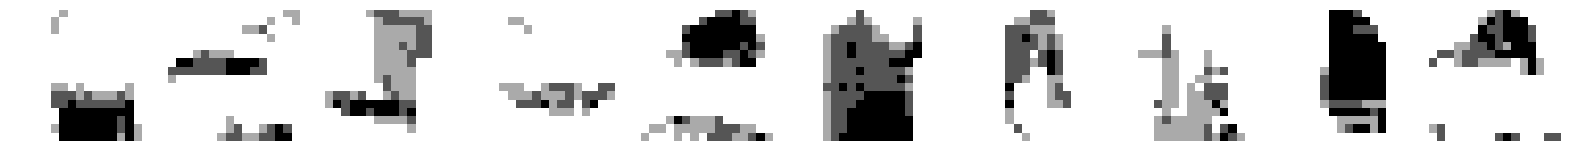

469/469 [==============================] - 24s 50ms/step - loss: 0.3890
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.3821
Saved to /content/images/generated_img_001.png


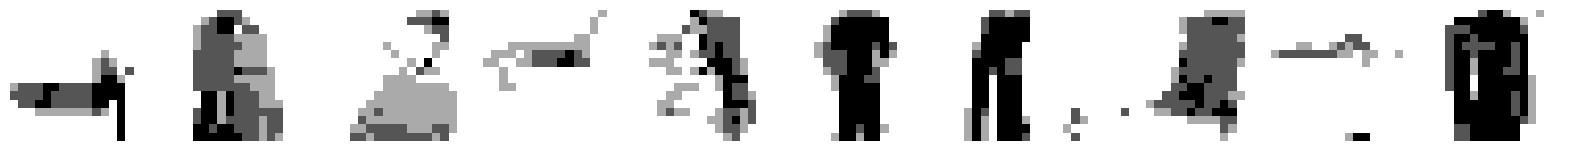

469/469 [==============================] - 23s 50ms/step - loss: 0.3821
Epoch 3/150
466/469 [============================>.] - ETA: 0s - loss: 0.3769
Saved to /content/images/generated_img_002.png


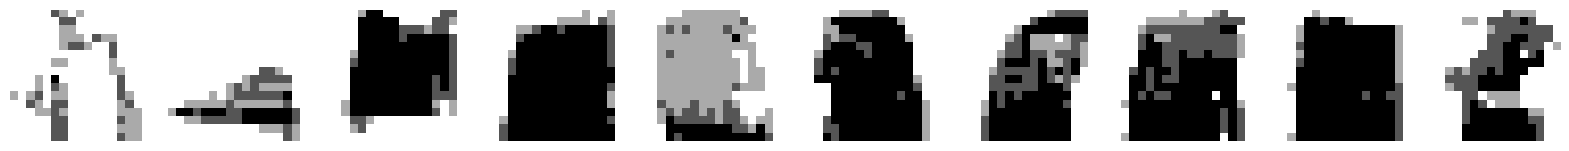

469/469 [==============================] - 20s 42ms/step - loss: 0.3769
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.3736
Saved to /content/images/generated_img_003.png


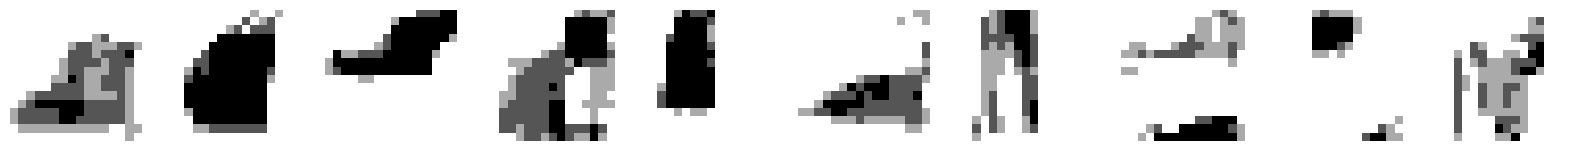

469/469 [==============================] - 19s 41ms/step - loss: 0.3736
Epoch 5/150
466/469 [============================>.] - ETA: 0s - loss: 0.3703
Saved to /content/images/generated_img_004.png


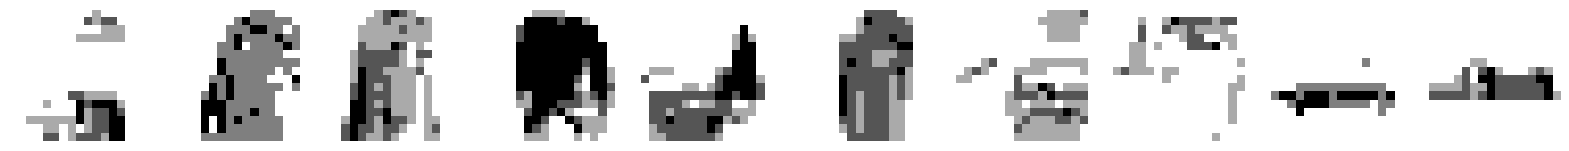

469/469 [==============================] - 19s 41ms/step - loss: 0.3702
Epoch 6/150
468/469 [============================>.] - ETA: 0s - loss: 0.3674
Saved to /content/images/generated_img_005.png


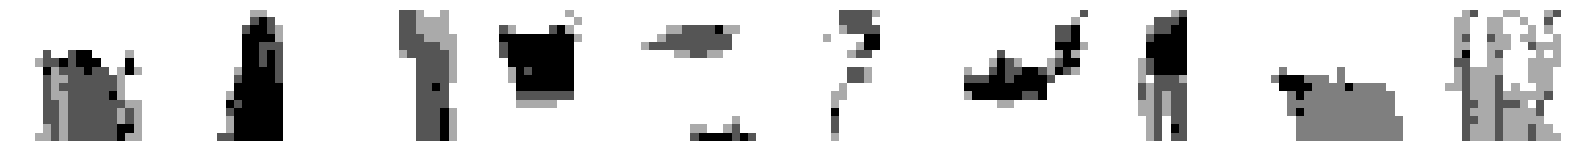

469/469 [==============================] - 20s 42ms/step - loss: 0.3674
Epoch 7/150
469/469 [==============================] - ETA: 0s - loss: 0.3645
Saved to /content/images/generated_img_006.png


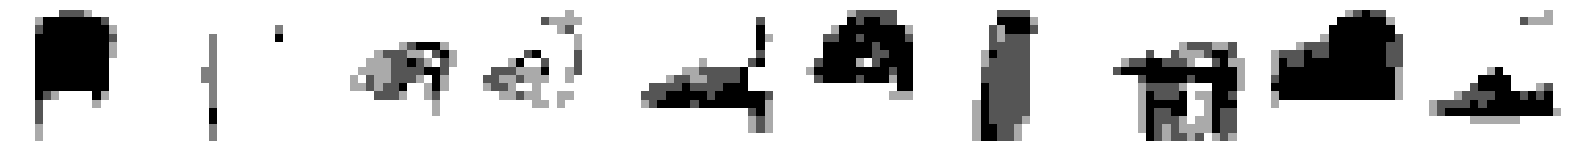

469/469 [==============================] - 19s 41ms/step - loss: 0.3645
Epoch 8/150
468/469 [============================>.] - ETA: 0s - loss: 0.3623
Saved to /content/images/generated_img_007.png


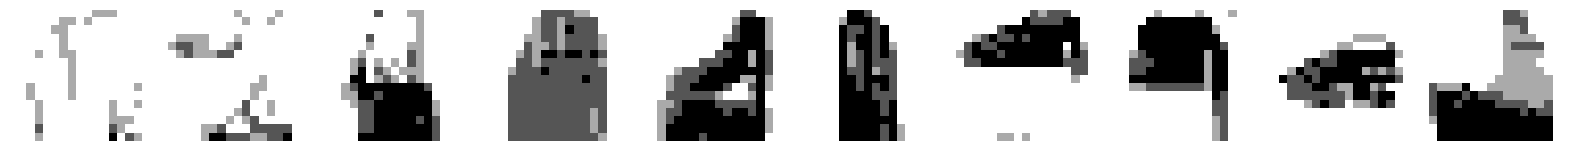

469/469 [==============================] - 20s 42ms/step - loss: 0.3622
Epoch 9/150
466/469 [============================>.] - ETA: 0s - loss: 0.3603
Saved to /content/images/generated_img_008.png


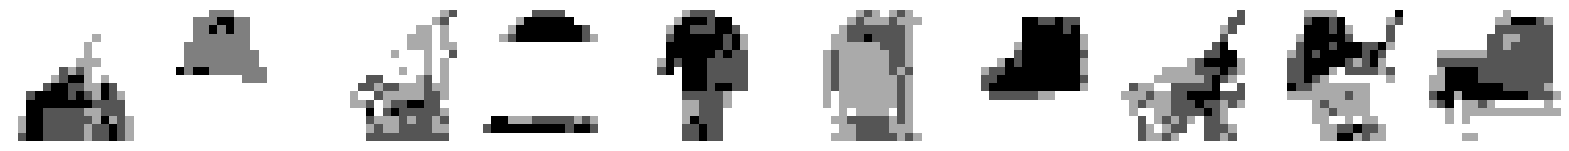

469/469 [==============================] - 20s 42ms/step - loss: 0.3603
Epoch 10/150
467/469 [============================>.] - ETA: 0s - loss: 0.3583
Saved to /content/images/generated_img_009.png


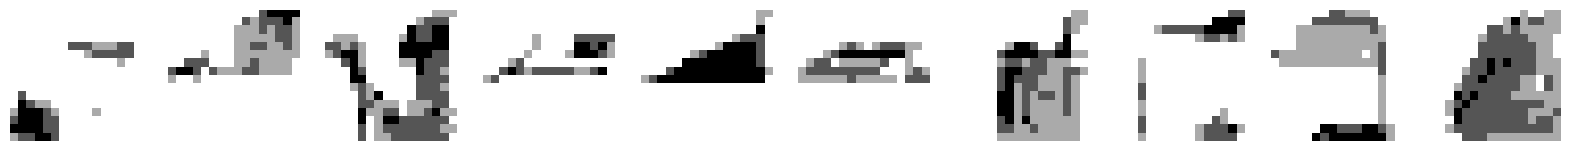

469/469 [==============================] - 19s 41ms/step - loss: 0.3583
Epoch 11/150
465/469 [============================>.] - ETA: 0s - loss: 0.3571
Saved to /content/images/generated_img_010.png


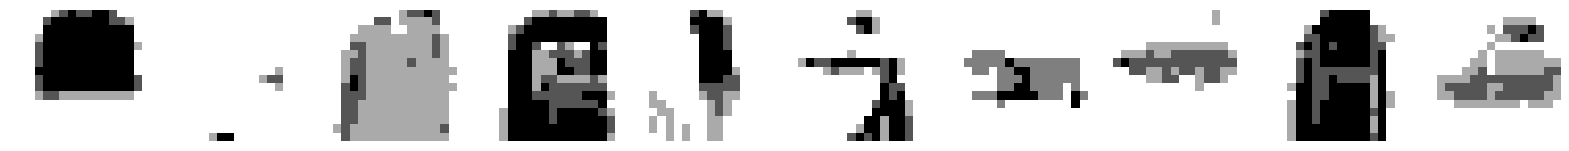

469/469 [==============================] - 20s 42ms/step - loss: 0.3571
Epoch 12/150
468/469 [============================>.] - ETA: 0s - loss: 0.3557
Saved to /content/images/generated_img_011.png


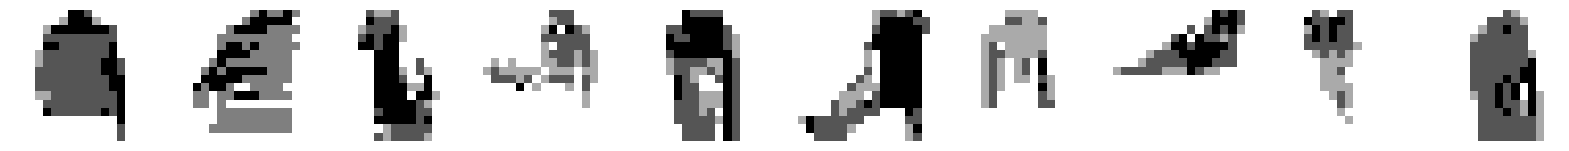

469/469 [==============================] - 20s 42ms/step - loss: 0.3557
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.3541
Saved to /content/images/generated_img_012.png


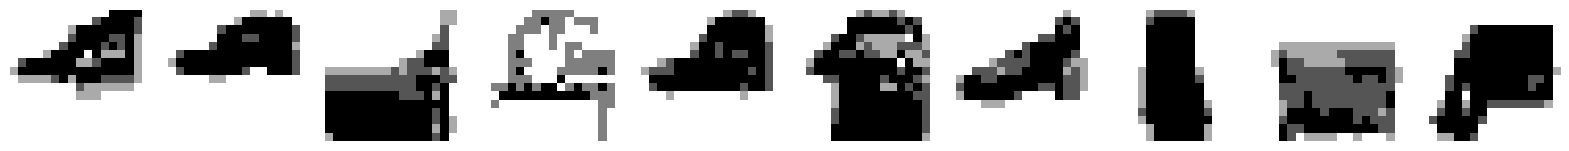

469/469 [==============================] - 19s 41ms/step - loss: 0.3541
Epoch 14/150
466/469 [============================>.] - ETA: 0s - loss: 0.3525
Saved to /content/images/generated_img_013.png


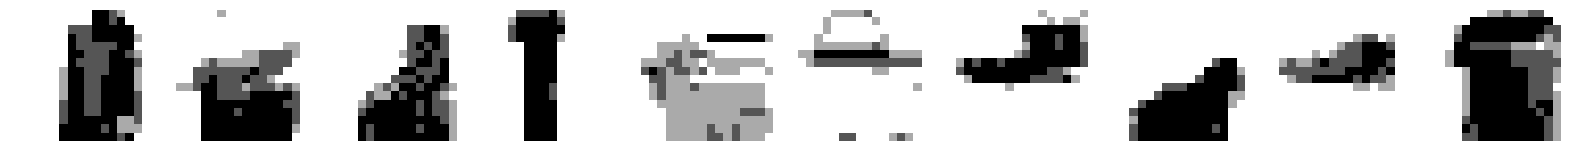

469/469 [==============================] - 20s 43ms/step - loss: 0.3525
Epoch 15/150
468/469 [============================>.] - ETA: 0s - loss: 0.3518
Saved to /content/images/generated_img_014.png


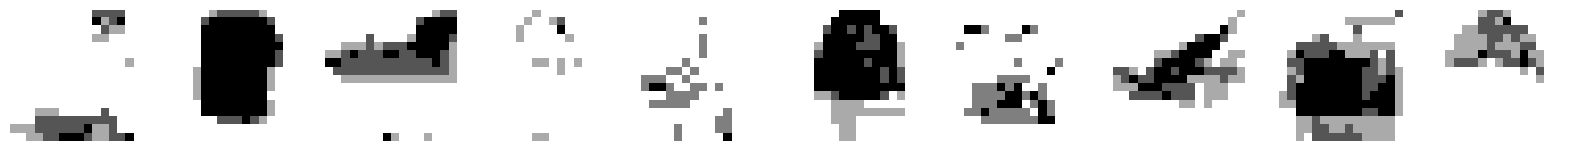

469/469 [==============================] - 19s 42ms/step - loss: 0.3518
Epoch 16/150
468/469 [============================>.] - ETA: 0s - loss: 0.3506
Saved to /content/images/generated_img_015.png


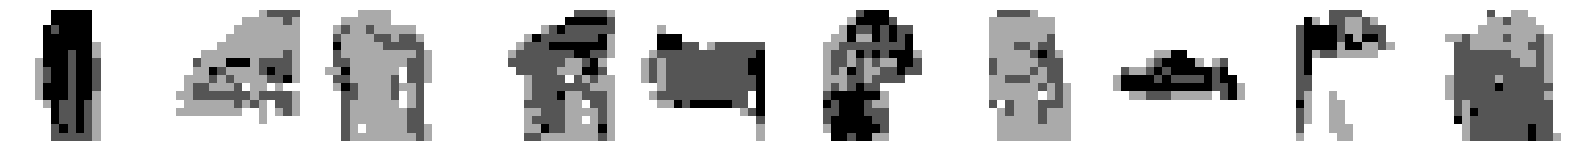

469/469 [==============================] - 20s 42ms/step - loss: 0.3506
Epoch 17/150
466/469 [============================>.] - ETA: 0s - loss: 0.3495
Saved to /content/images/generated_img_016.png


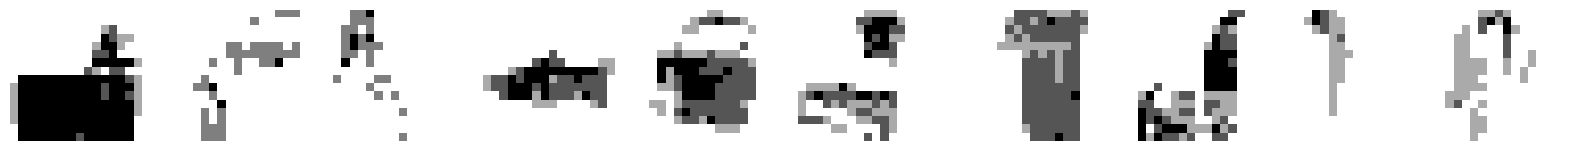

469/469 [==============================] - 20s 42ms/step - loss: 0.3496
Epoch 18/150
467/469 [============================>.] - ETA: 0s - loss: 0.3489
Saved to /content/images/generated_img_017.png


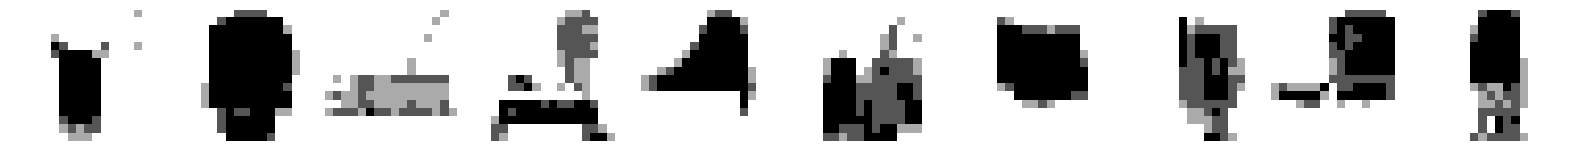

469/469 [==============================] - 19s 42ms/step - loss: 0.3488
Epoch 19/150
467/469 [============================>.] - ETA: 0s - loss: 0.3478
Saved to /content/images/generated_img_018.png


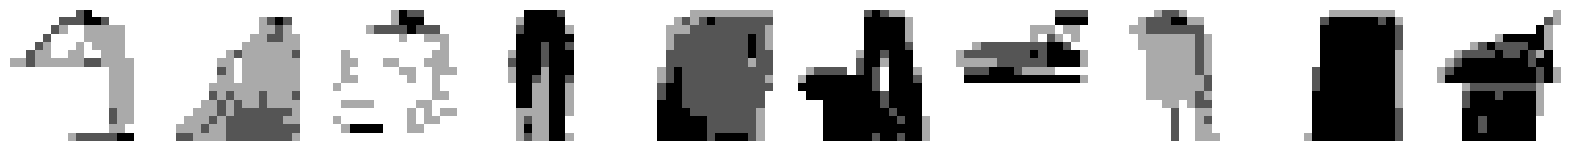

469/469 [==============================] - 20s 43ms/step - loss: 0.3479
Epoch 20/150
466/469 [============================>.] - ETA: 0s - loss: 0.3469
Saved to /content/images/generated_img_019.png


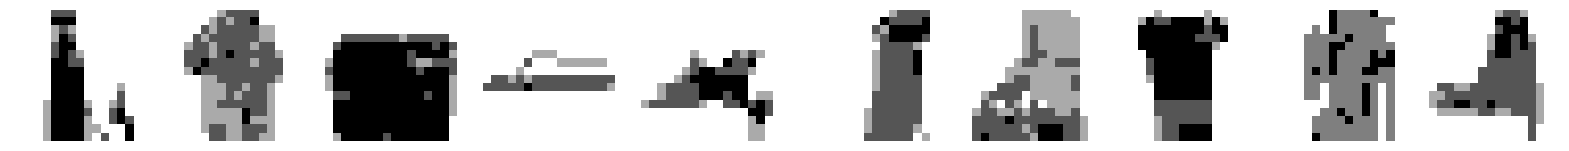

469/469 [==============================] - 19s 41ms/step - loss: 0.3468
Epoch 21/150
468/469 [============================>.] - ETA: 0s - loss: 0.3464
Saved to /content/images/generated_img_020.png


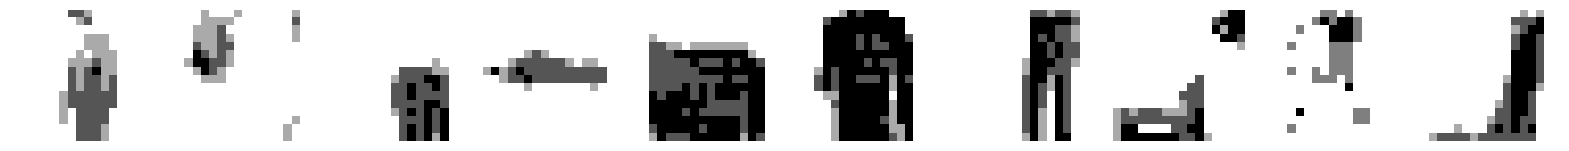

469/469 [==============================] - 20s 42ms/step - loss: 0.3464
Epoch 22/150
468/469 [============================>.] - ETA: 0s - loss: 0.3454
Saved to /content/images/generated_img_021.png


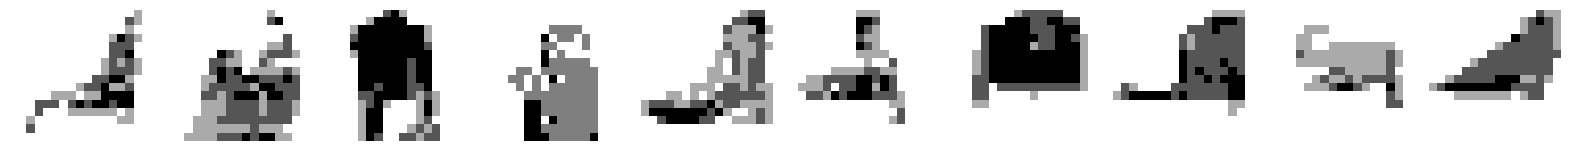

469/469 [==============================] - 20s 42ms/step - loss: 0.3454
Epoch 23/150
468/469 [============================>.] - ETA: 0s - loss: 0.3449
Saved to /content/images/generated_img_022.png


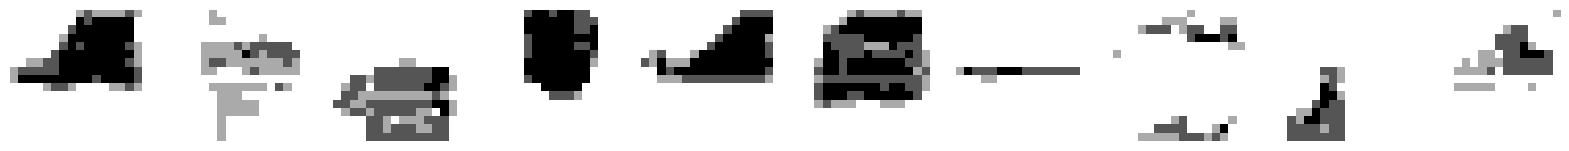

469/469 [==============================] - 19s 41ms/step - loss: 0.3449
Epoch 24/150
465/469 [============================>.] - ETA: 0s - loss: 0.3443
Saved to /content/images/generated_img_023.png


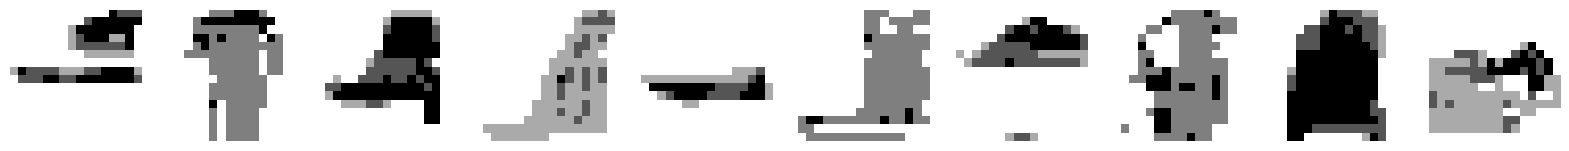

469/469 [==============================] - 21s 44ms/step - loss: 0.3443
Epoch 25/150
468/469 [============================>.] - ETA: 0s - loss: 0.3435
Saved to /content/images/generated_img_024.png


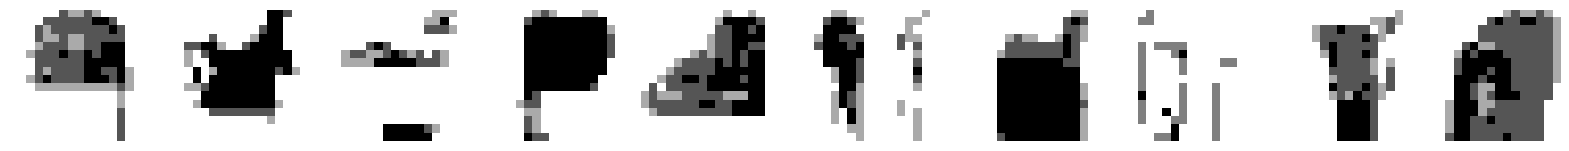

469/469 [==============================] - 20s 42ms/step - loss: 0.3434
Epoch 26/150
468/469 [============================>.] - ETA: 0s - loss: 0.3430
Saved to /content/images/generated_img_025.png


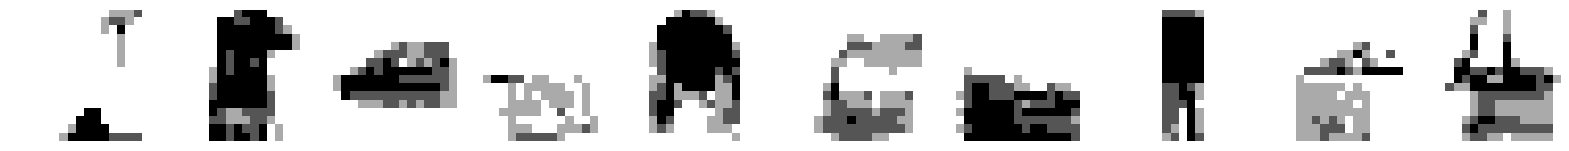

469/469 [==============================] - 20s 42ms/step - loss: 0.3429
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3425
Saved to /content/images/generated_img_026.png


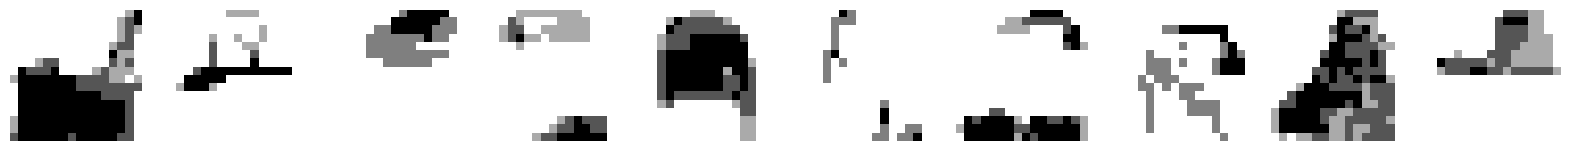

469/469 [==============================] - 21s 45ms/step - loss: 0.3425
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3420
Saved to /content/images/generated_img_027.png


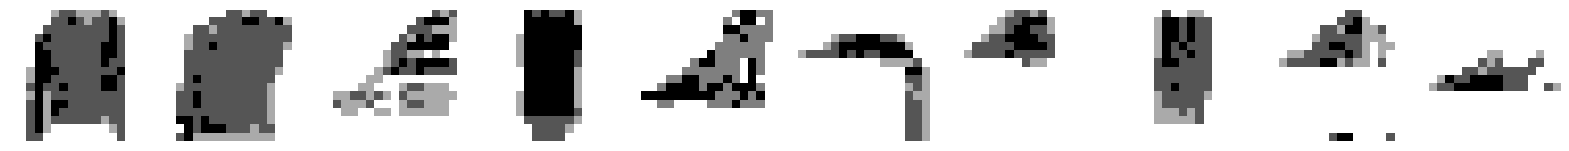

469/469 [==============================] - 20s 42ms/step - loss: 0.3420
Epoch 29/150
466/469 [============================>.] - ETA: 0s - loss: 0.3415
Saved to /content/images/generated_img_028.png


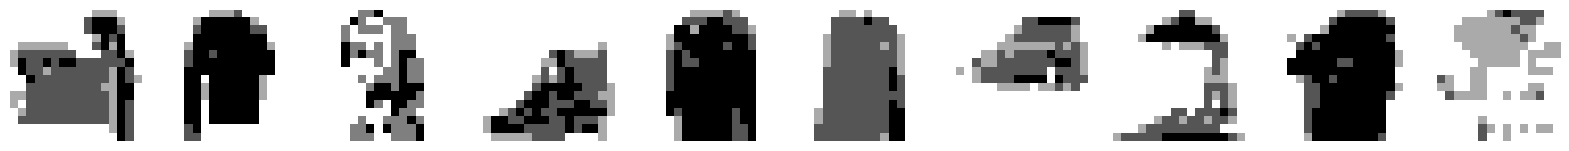

469/469 [==============================] - 21s 44ms/step - loss: 0.3416
Epoch 30/150
466/469 [============================>.] - ETA: 0s - loss: 0.3410
Saved to /content/images/generated_img_029.png


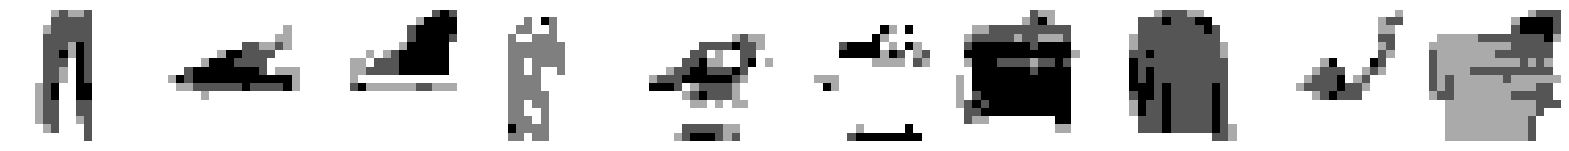

469/469 [==============================] - 20s 42ms/step - loss: 0.3410
Epoch 31/150
468/469 [============================>.] - ETA: 0s - loss: 0.3407
Saved to /content/images/generated_img_030.png


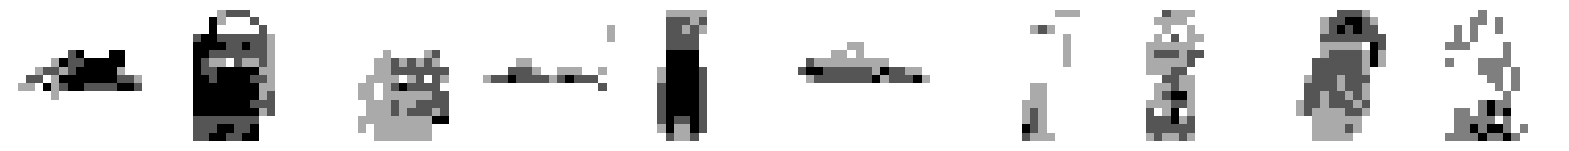

469/469 [==============================] - 20s 42ms/step - loss: 0.3407
Epoch 32/150
467/469 [============================>.] - ETA: 0s - loss: 0.3404
Saved to /content/images/generated_img_031.png


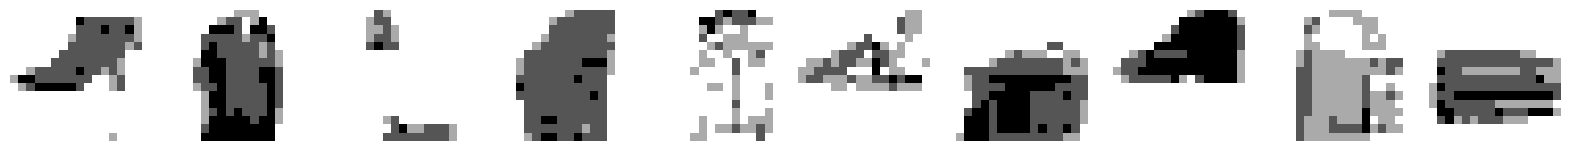

469/469 [==============================] - 20s 43ms/step - loss: 0.3403
Epoch 33/150
466/469 [============================>.] - ETA: 0s - loss: 0.3396
Saved to /content/images/generated_img_032.png


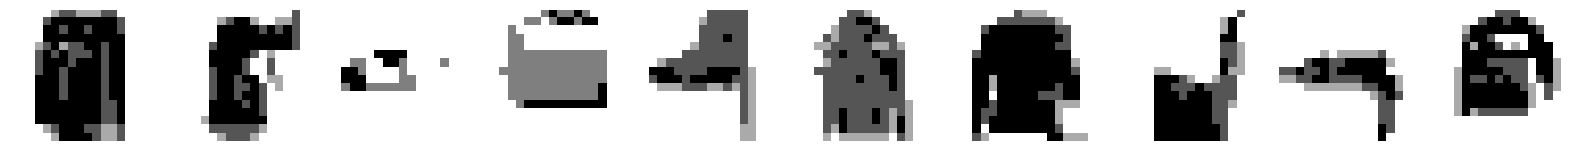

469/469 [==============================] - 20s 42ms/step - loss: 0.3397
Epoch 34/150
466/469 [============================>.] - ETA: 0s - loss: 0.3394
Saved to /content/images/generated_img_033.png


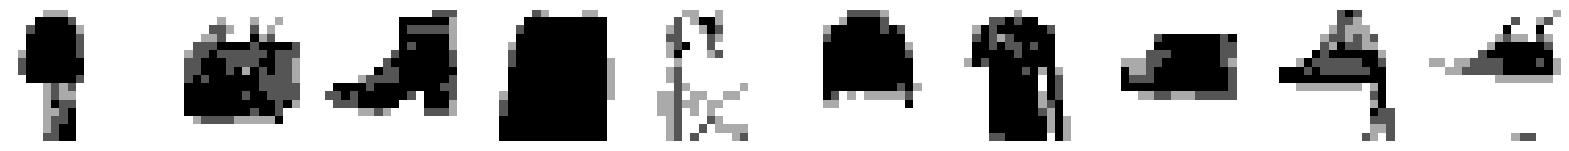

469/469 [==============================] - 20s 43ms/step - loss: 0.3394
Epoch 35/150
465/469 [============================>.] - ETA: 0s - loss: 0.3389
Saved to /content/images/generated_img_034.png


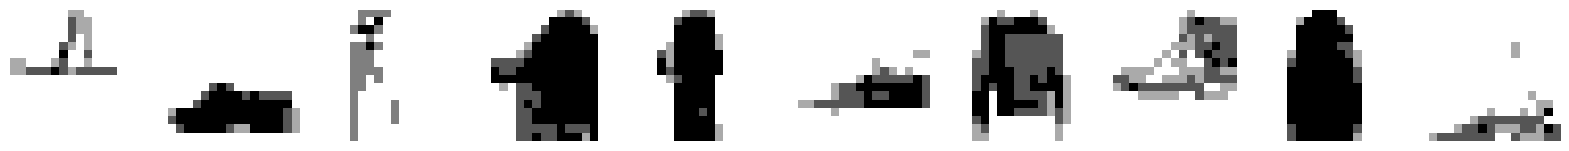

469/469 [==============================] - 20s 42ms/step - loss: 0.3390
Epoch 36/150
464/469 [============================>.] - ETA: 0s - loss: 0.3385
Saved to /content/images/generated_img_035.png


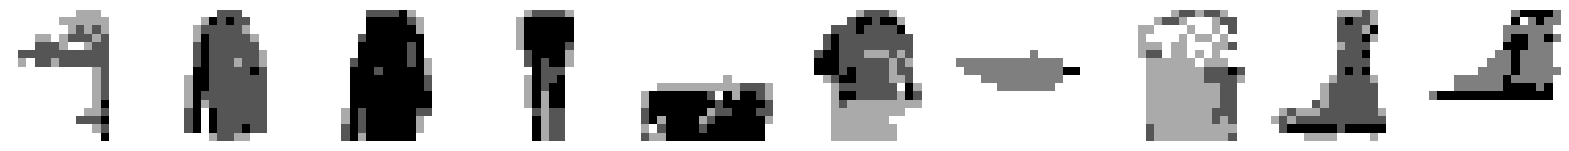

469/469 [==============================] - 20s 42ms/step - loss: 0.3385
Epoch 37/150
467/469 [============================>.] - ETA: 0s - loss: 0.3380
Saved to /content/images/generated_img_036.png


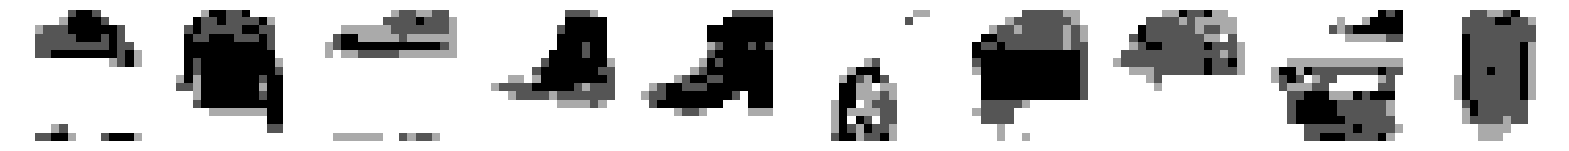

469/469 [==============================] - 20s 43ms/step - loss: 0.3380
Epoch 38/150
467/469 [============================>.] - ETA: 0s - loss: 0.3379
Saved to /content/images/generated_img_037.png


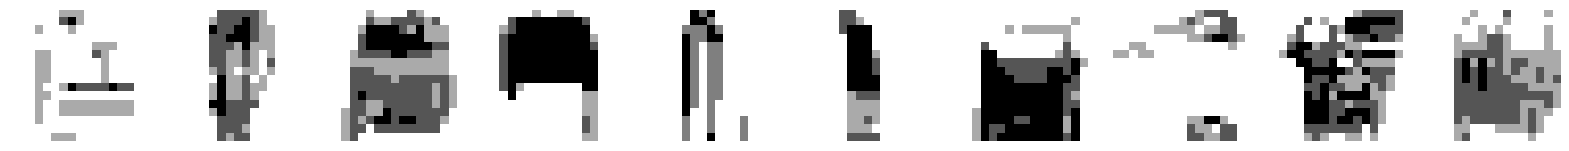

469/469 [==============================] - 19s 42ms/step - loss: 0.3380
Epoch 39/150
464/469 [============================>.] - ETA: 0s - loss: 0.3375
Saved to /content/images/generated_img_038.png


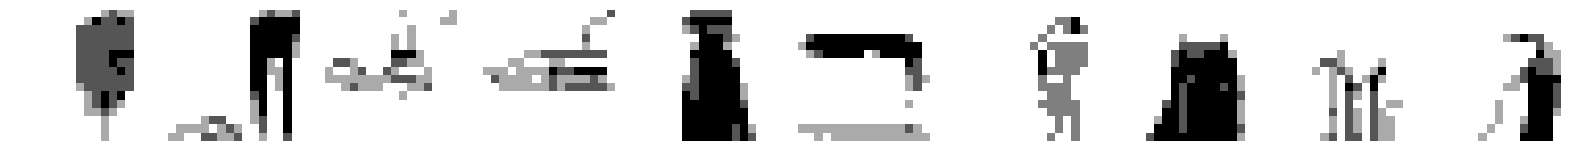

469/469 [==============================] - 21s 45ms/step - loss: 0.3375
Epoch 40/150
468/469 [============================>.] - ETA: 0s - loss: 0.3369
Saved to /content/images/generated_img_039.png


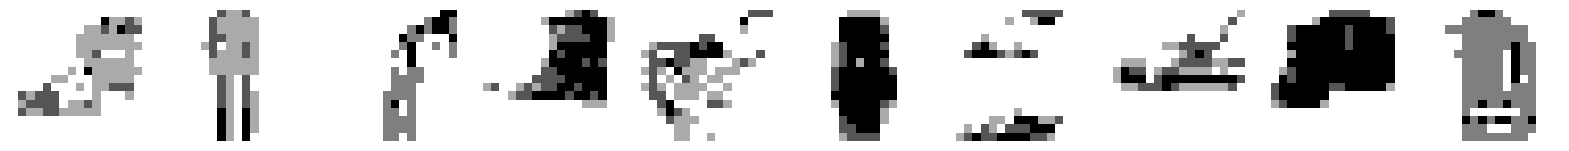

469/469 [==============================] - 20s 42ms/step - loss: 0.3370
Epoch 41/150
468/469 [============================>.] - ETA: 0s - loss: 0.3370
Saved to /content/images/generated_img_040.png


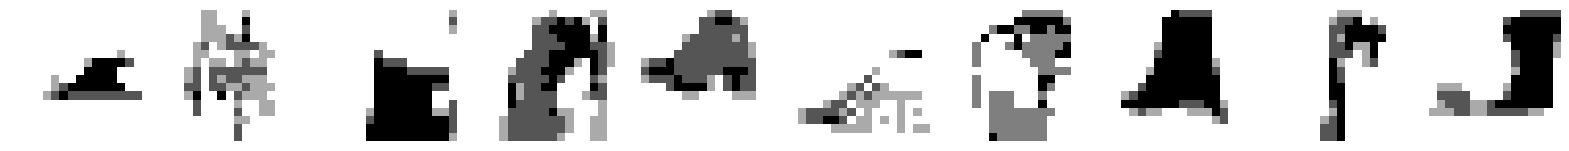

469/469 [==============================] - 20s 42ms/step - loss: 0.3370
Epoch 42/150
467/469 [============================>.] - ETA: 0s - loss: 0.3365
Saved to /content/images/generated_img_041.png


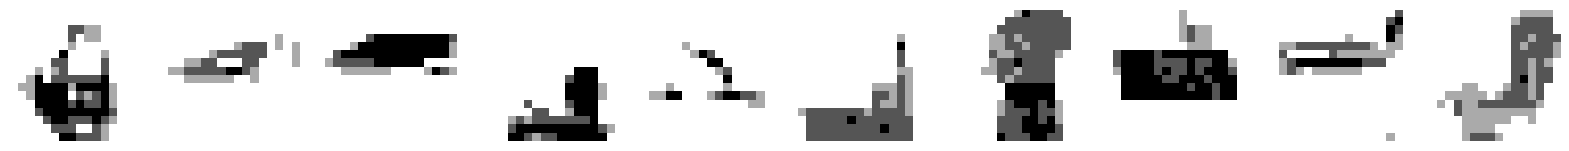

469/469 [==============================] - 20s 44ms/step - loss: 0.3365
Epoch 43/150
469/469 [==============================] - ETA: 0s - loss: 0.3363
Saved to /content/images/generated_img_042.png


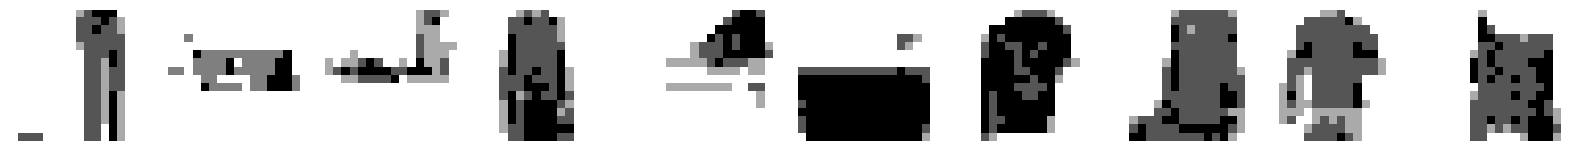

469/469 [==============================] - 20s 42ms/step - loss: 0.3363
Epoch 44/150
467/469 [============================>.] - ETA: 0s - loss: 0.3360
Saved to /content/images/generated_img_043.png


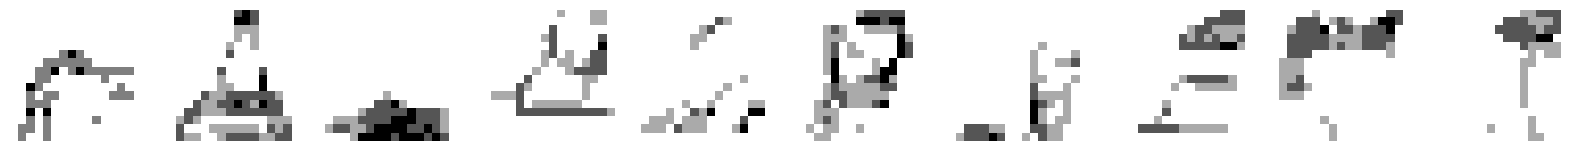

469/469 [==============================] - 21s 44ms/step - loss: 0.3360
Epoch 45/150
468/469 [============================>.] - ETA: 0s - loss: 0.3358
Saved to /content/images/generated_img_044.png


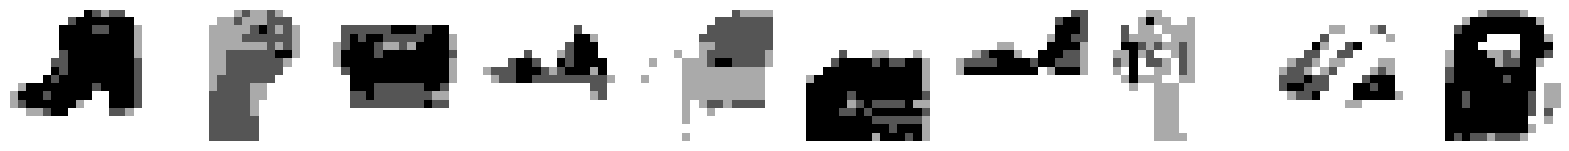

469/469 [==============================] - 19s 42ms/step - loss: 0.3357
Epoch 46/150
468/469 [============================>.] - ETA: 0s - loss: 0.3355
Saved to /content/images/generated_img_045.png


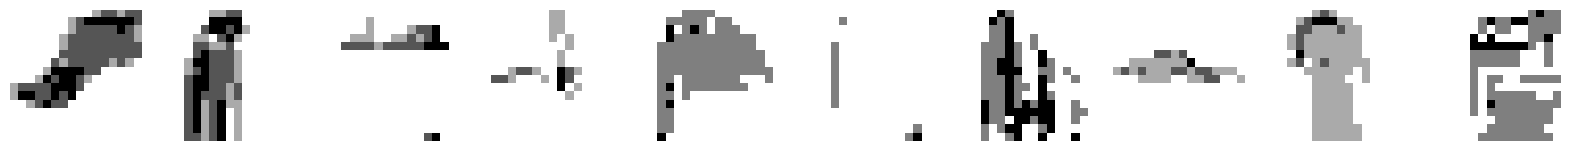

469/469 [==============================] - 20s 42ms/step - loss: 0.3355
Epoch 47/150
469/469 [==============================] - ETA: 0s - loss: 0.3350
Saved to /content/images/generated_img_046.png


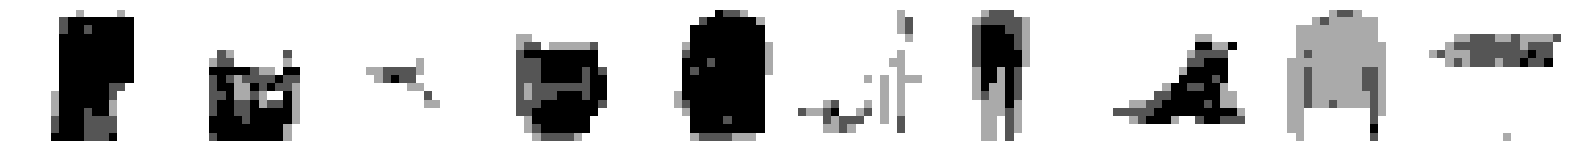

469/469 [==============================] - 20s 44ms/step - loss: 0.3350
Epoch 48/150
465/469 [============================>.] - ETA: 0s - loss: 0.3348
Saved to /content/images/generated_img_047.png


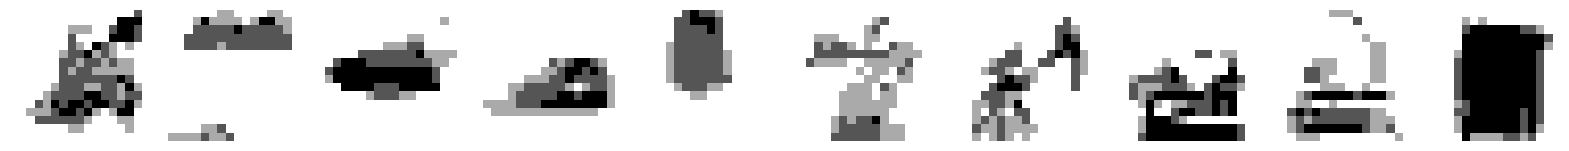

469/469 [==============================] - 19s 42ms/step - loss: 0.3347
Epoch 49/150
467/469 [============================>.] - ETA: 0s - loss: 0.3348
Saved to /content/images/generated_img_048.png


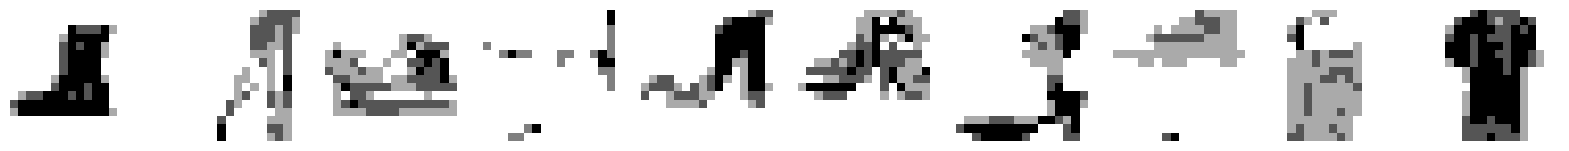

469/469 [==============================] - 21s 44ms/step - loss: 0.3348
Epoch 50/150
466/469 [============================>.] - ETA: 0s - loss: 0.3344
Saved to /content/images/generated_img_049.png


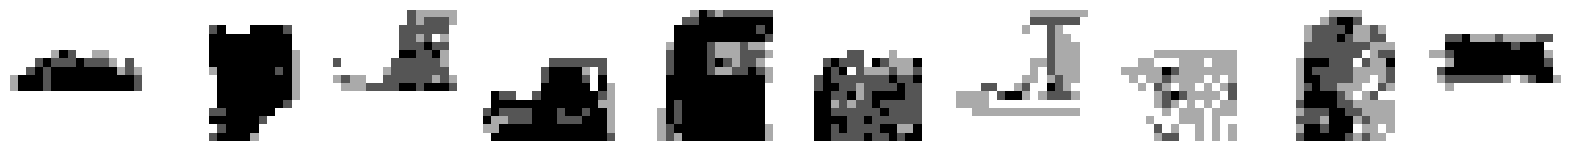

469/469 [==============================] - 20s 42ms/step - loss: 0.3344
Epoch 51/150
466/469 [============================>.] - ETA: 0s - loss: 0.3341
Saved to /content/images/generated_img_050.png


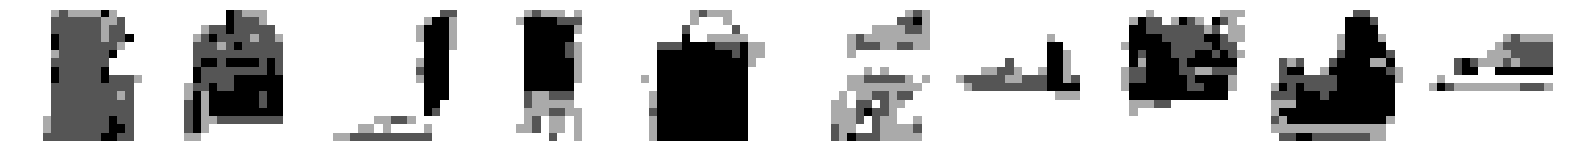

469/469 [==============================] - 20s 42ms/step - loss: 0.3341
Epoch 52/150
467/469 [============================>.] - ETA: 0s - loss: 0.3337
Saved to /content/images/generated_img_051.png


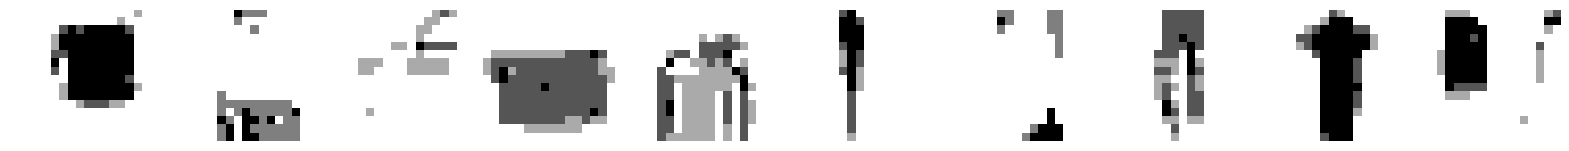

469/469 [==============================] - 20s 44ms/step - loss: 0.3338
Epoch 53/150
467/469 [============================>.] - ETA: 0s - loss: 0.3338
Saved to /content/images/generated_img_052.png


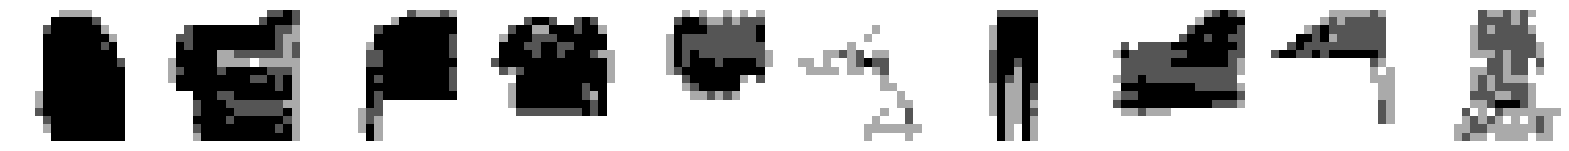

469/469 [==============================] - 19s 41ms/step - loss: 0.3338
Epoch 54/150
464/469 [============================>.] - ETA: 0s - loss: 0.3334
Saved to /content/images/generated_img_053.png


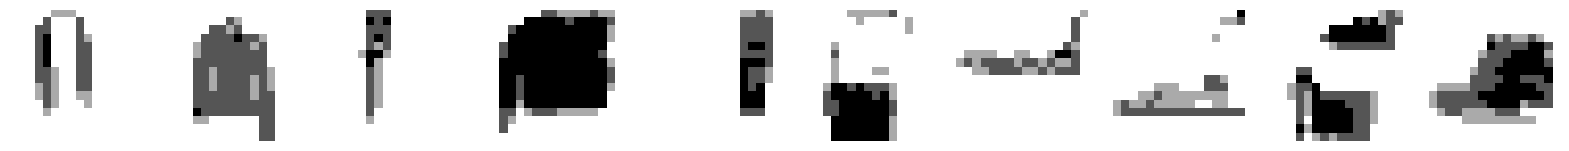

469/469 [==============================] - 21s 44ms/step - loss: 0.3334
Epoch 55/150
467/469 [============================>.] - ETA: 0s - loss: 0.3332
Saved to /content/images/generated_img_054.png


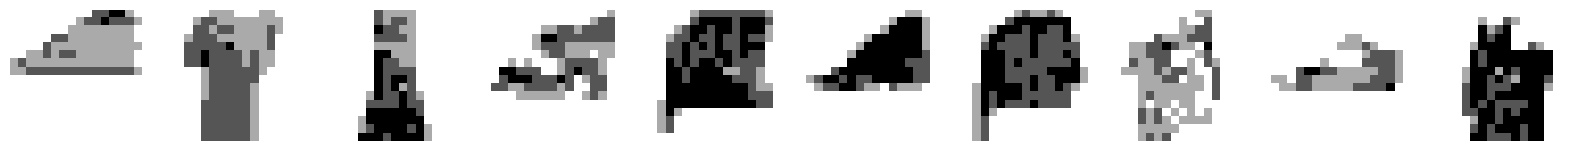

469/469 [==============================] - 20s 43ms/step - loss: 0.3332
Epoch 56/150
465/469 [============================>.] - ETA: 0s - loss: 0.3329
Saved to /content/images/generated_img_055.png


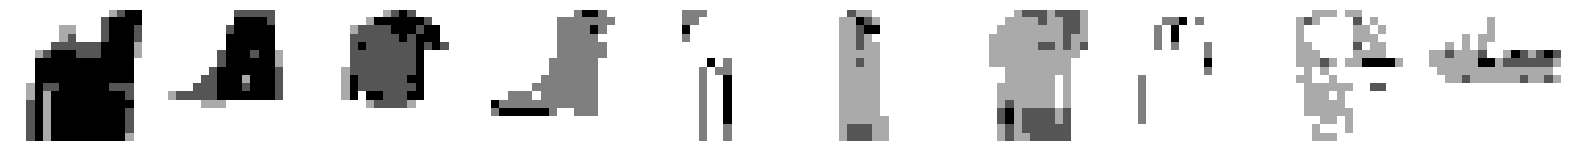

469/469 [==============================] - 20s 43ms/step - loss: 0.3330
Epoch 57/150
466/469 [============================>.] - ETA: 0s - loss: 0.3327
Saved to /content/images/generated_img_056.png


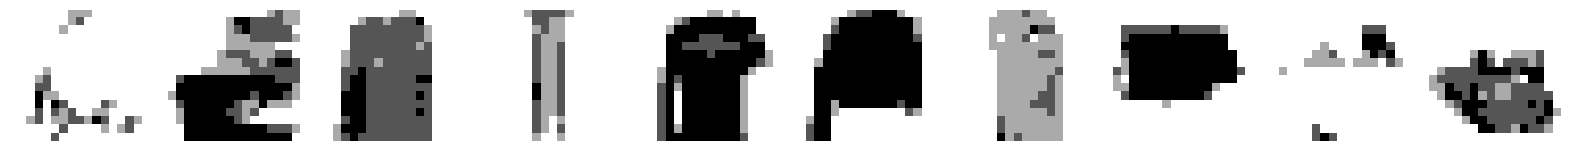

469/469 [==============================] - 21s 45ms/step - loss: 0.3327
Epoch 58/150
464/469 [============================>.] - ETA: 0s - loss: 0.3325
Saved to /content/images/generated_img_057.png


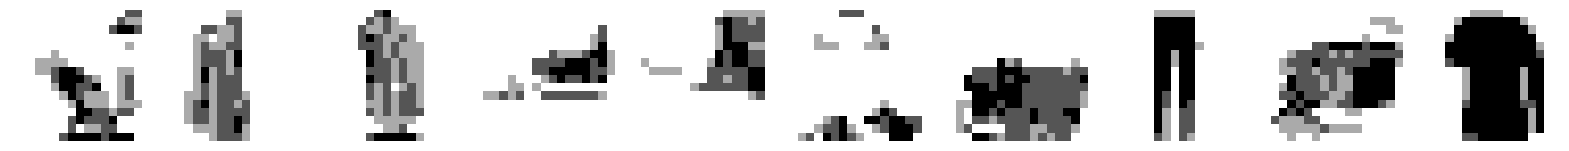

469/469 [==============================] - 20s 42ms/step - loss: 0.3325
Epoch 59/150
466/469 [============================>.] - ETA: 0s - loss: 0.3324
Saved to /content/images/generated_img_058.png


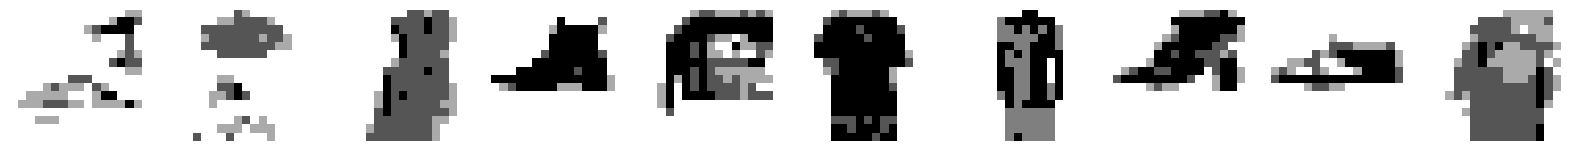

469/469 [==============================] - 21s 44ms/step - loss: 0.3324
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.3322
Saved to /content/images/generated_img_059.png


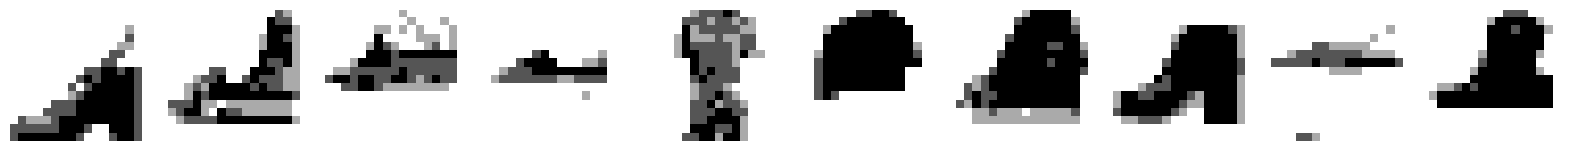

469/469 [==============================] - 20s 42ms/step - loss: 0.3322
Epoch 61/150
467/469 [============================>.] - ETA: 0s - loss: 0.3319
Saved to /content/images/generated_img_060.png


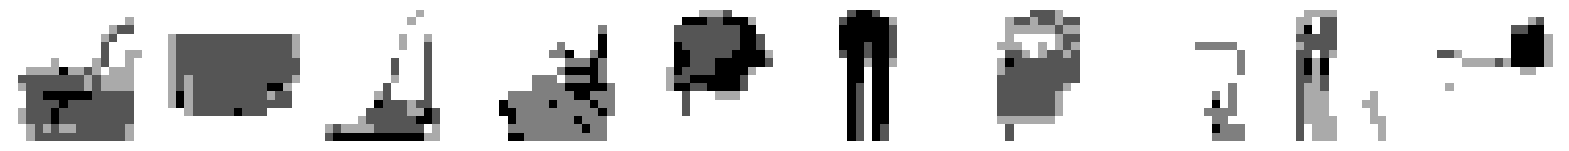

469/469 [==============================] - 20s 42ms/step - loss: 0.3319
Epoch 62/150
467/469 [============================>.] - ETA: 0s - loss: 0.3319
Saved to /content/images/generated_img_061.png


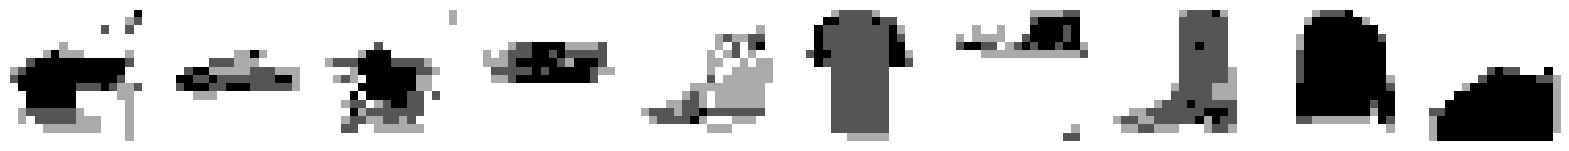

469/469 [==============================] - 21s 44ms/step - loss: 0.3319
Epoch 63/150
467/469 [============================>.] - ETA: 0s - loss: 0.3319
Saved to /content/images/generated_img_062.png


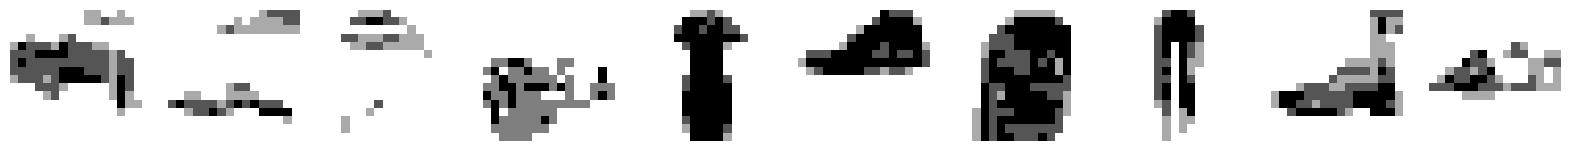

469/469 [==============================] - 20s 42ms/step - loss: 0.3318
Epoch 64/150
468/469 [============================>.] - ETA: 0s - loss: 0.3316
Saved to /content/images/generated_img_063.png


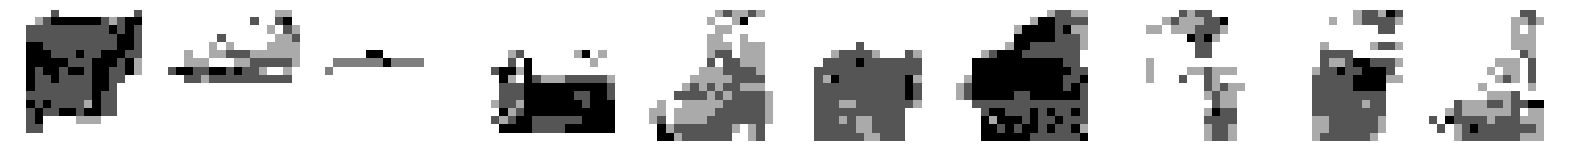

469/469 [==============================] - 20s 44ms/step - loss: 0.3316
Epoch 65/150
466/469 [============================>.] - ETA: 0s - loss: 0.3312
Saved to /content/images/generated_img_064.png


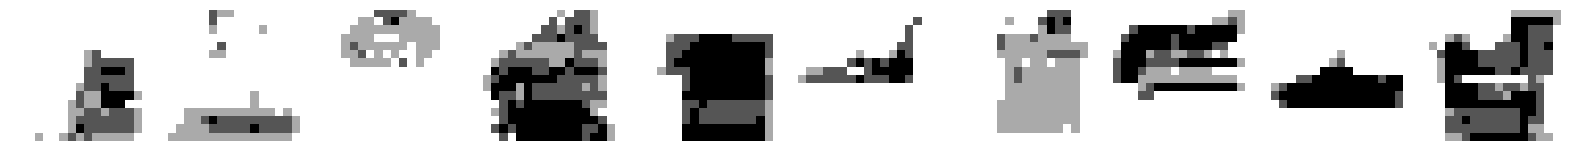

469/469 [==============================] - 20s 43ms/step - loss: 0.3312
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3310
Saved to /content/images/generated_img_065.png


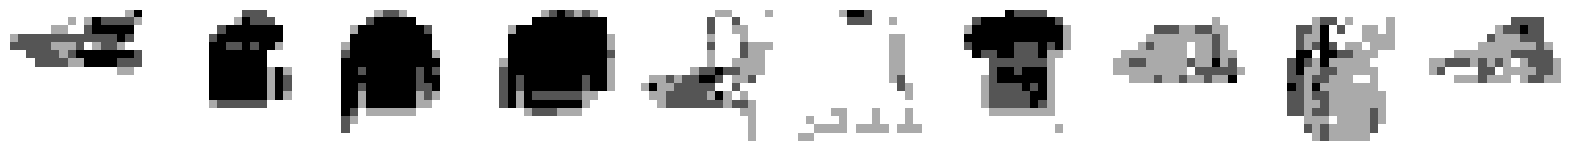

469/469 [==============================] - 20s 43ms/step - loss: 0.3310
Epoch 67/150
468/469 [============================>.] - ETA: 0s - loss: 0.3310
Saved to /content/images/generated_img_066.png


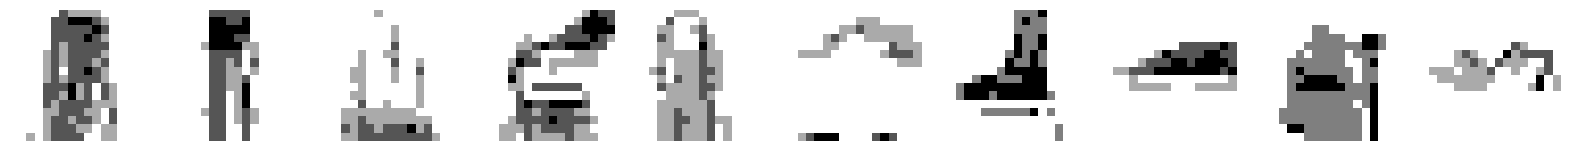

469/469 [==============================] - 21s 45ms/step - loss: 0.3310
Epoch 68/150
468/469 [============================>.] - ETA: 0s - loss: 0.3307
Saved to /content/images/generated_img_067.png


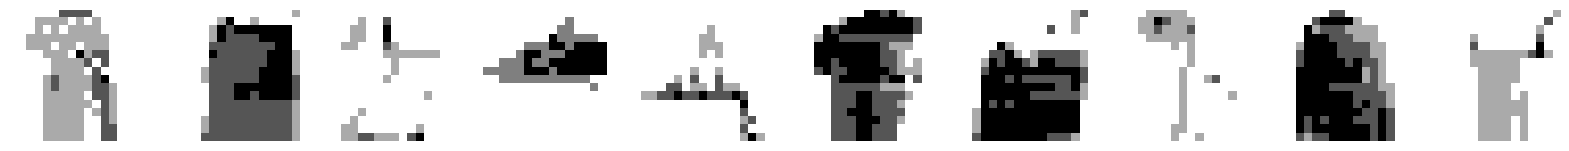

469/469 [==============================] - 19s 41ms/step - loss: 0.3307
Epoch 69/150
468/469 [============================>.] - ETA: 0s - loss: 0.3307
Saved to /content/images/generated_img_068.png


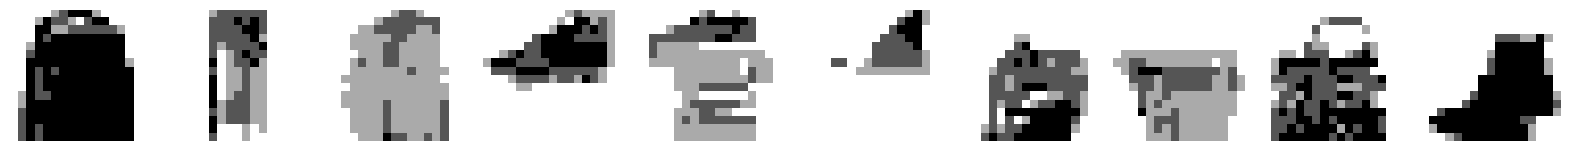

469/469 [==============================] - 19s 41ms/step - loss: 0.3307
Epoch 70/150
468/469 [============================>.] - ETA: 0s - loss: 0.3304
Saved to /content/images/generated_img_069.png


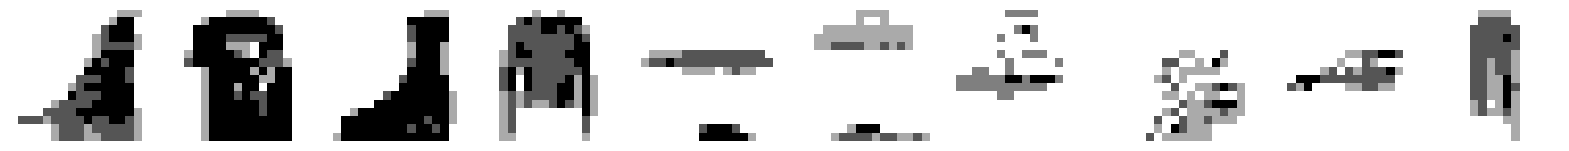

469/469 [==============================] - 20s 44ms/step - loss: 0.3304
Epoch 71/150
467/469 [============================>.] - ETA: 0s - loss: 0.3302
Saved to /content/images/generated_img_070.png


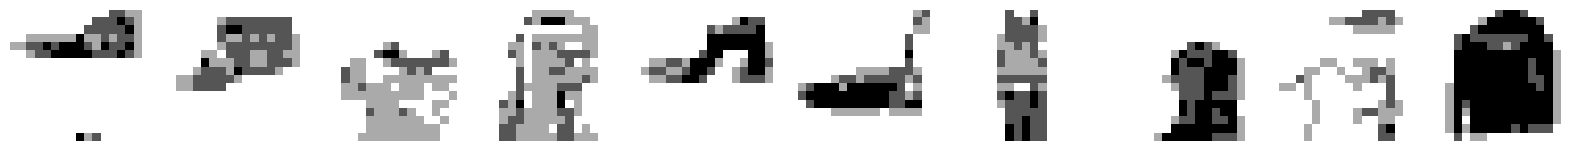

469/469 [==============================] - 20s 42ms/step - loss: 0.3302
Epoch 72/150
468/469 [============================>.] - ETA: 0s - loss: 0.3301
Saved to /content/images/generated_img_071.png


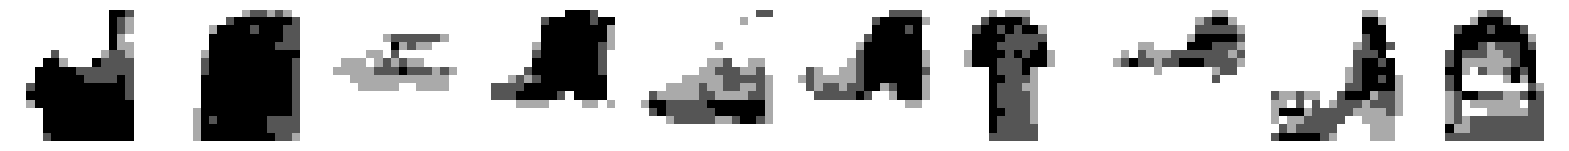

469/469 [==============================] - 21s 45ms/step - loss: 0.3301
Epoch 73/150
468/469 [============================>.] - ETA: 0s - loss: 0.3299
Saved to /content/images/generated_img_072.png


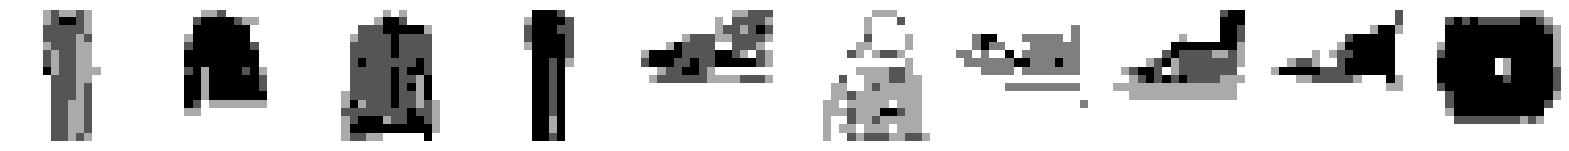

469/469 [==============================] - 20s 42ms/step - loss: 0.3299
Epoch 74/150
464/469 [============================>.] - ETA: 0s - loss: 0.3298
Saved to /content/images/generated_img_073.png


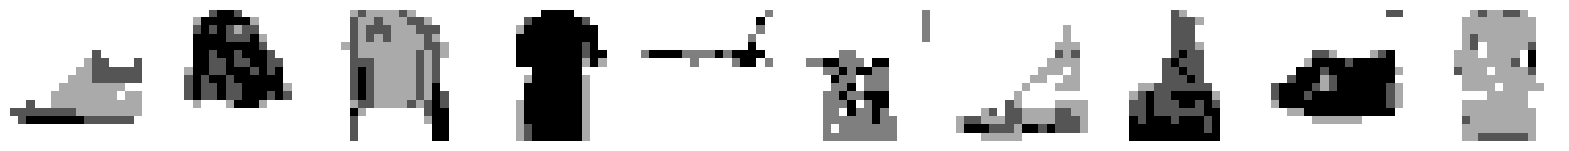

469/469 [==============================] - 20s 42ms/step - loss: 0.3298
Epoch 75/150
466/469 [============================>.] - ETA: 0s - loss: 0.3298
Saved to /content/images/generated_img_074.png


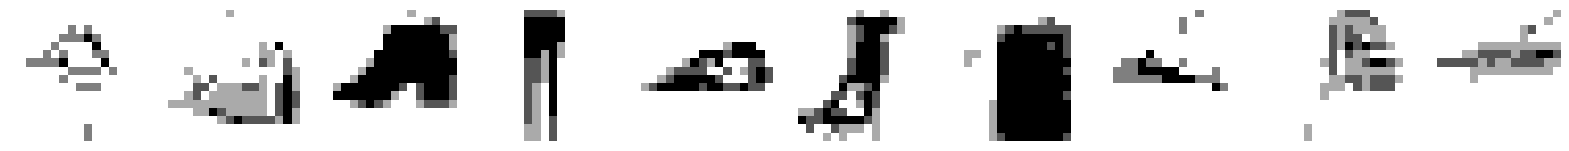

469/469 [==============================] - 21s 44ms/step - loss: 0.3298
Epoch 76/150
465/469 [============================>.] - ETA: 0s - loss: 0.3295
Saved to /content/images/generated_img_075.png


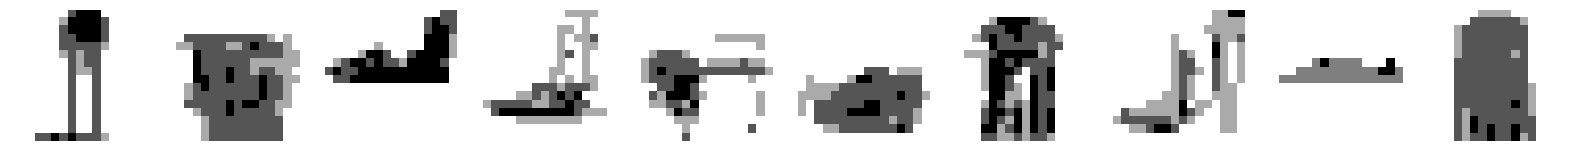

469/469 [==============================] - 20s 42ms/step - loss: 0.3295
Epoch 77/150
467/469 [============================>.] - ETA: 0s - loss: 0.3294
Saved to /content/images/generated_img_076.png


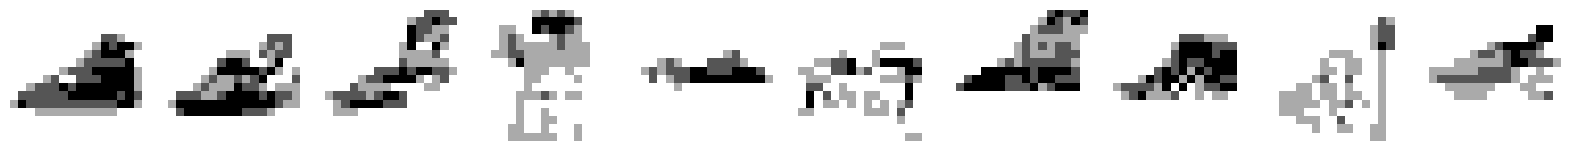

469/469 [==============================] - 21s 44ms/step - loss: 0.3294
Epoch 78/150
465/469 [============================>.] - ETA: 0s - loss: 0.3293
Saved to /content/images/generated_img_077.png


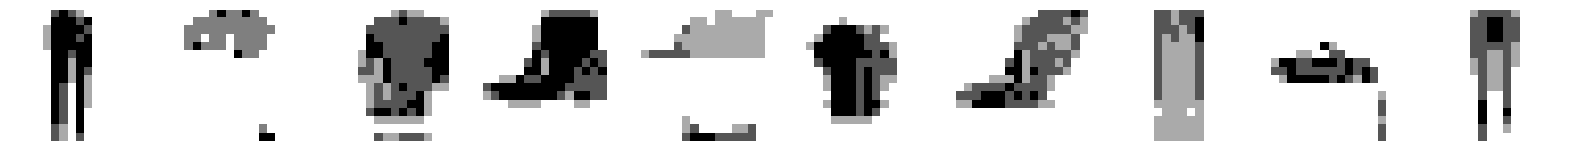

469/469 [==============================] - 20s 43ms/step - loss: 0.3293
Epoch 79/150
467/469 [============================>.] - ETA: 0s - loss: 0.3292
Saved to /content/images/generated_img_078.png


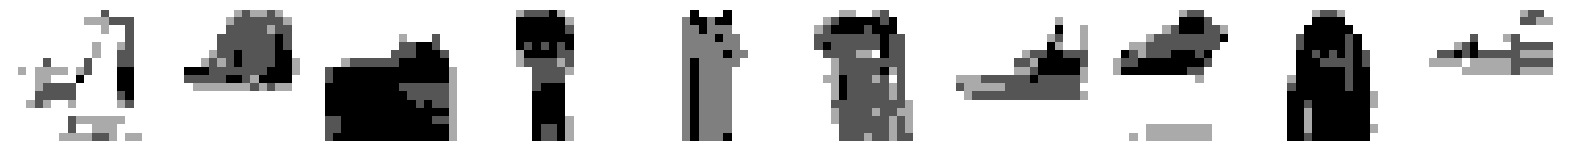

469/469 [==============================] - 20s 43ms/step - loss: 0.3291
Epoch 80/150
466/469 [============================>.] - ETA: 0s - loss: 0.3289
Saved to /content/images/generated_img_079.png


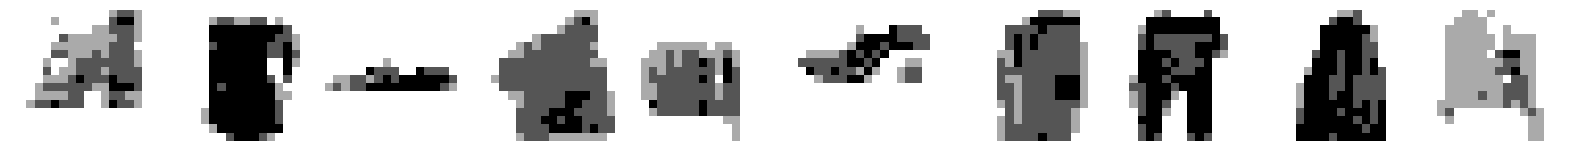

469/469 [==============================] - 21s 44ms/step - loss: 0.3290
Epoch 81/150
466/469 [============================>.] - ETA: 0s - loss: 0.3288
Saved to /content/images/generated_img_080.png


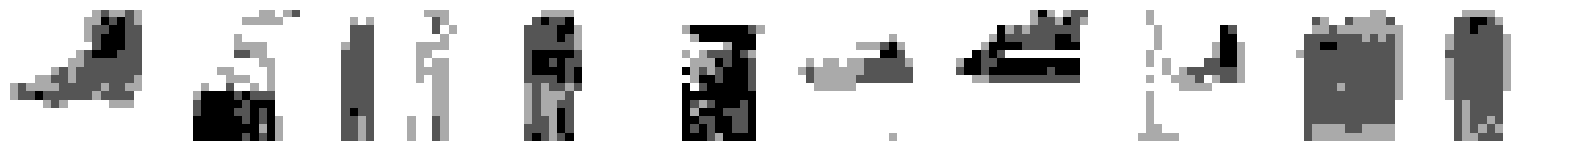

469/469 [==============================] - 20s 42ms/step - loss: 0.3289
Epoch 82/150
464/469 [============================>.] - ETA: 0s - loss: 0.3287
Saved to /content/images/generated_img_081.png


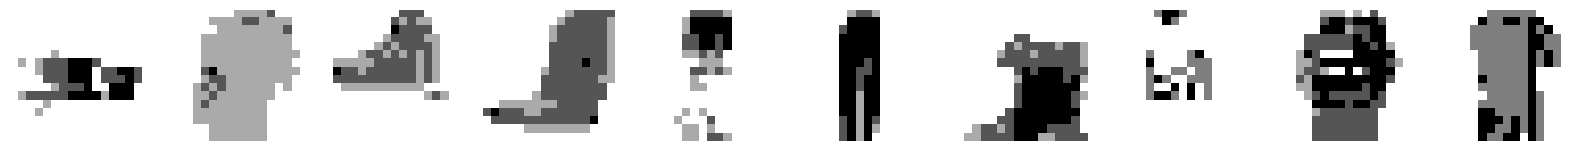

469/469 [==============================] - 20s 42ms/step - loss: 0.3287
Epoch 83/150
466/469 [============================>.] - ETA: 0s - loss: 0.3287
Saved to /content/images/generated_img_082.png


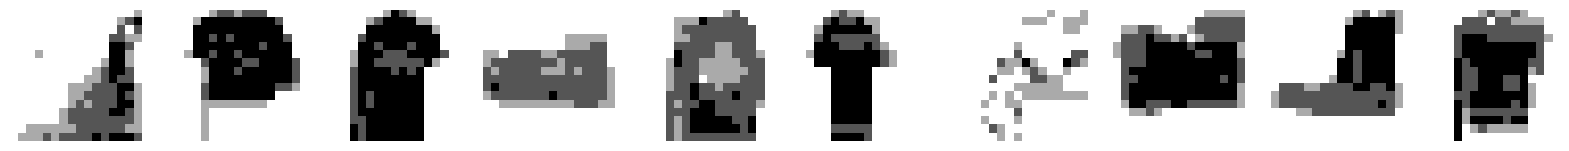

469/469 [==============================] - 21s 44ms/step - loss: 0.3286
Epoch 84/150
466/469 [============================>.] - ETA: 0s - loss: 0.3285
Saved to /content/images/generated_img_083.png


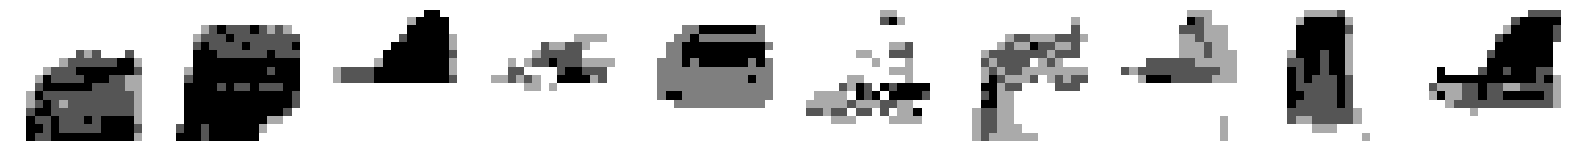

469/469 [==============================] - 20s 42ms/step - loss: 0.3285
Epoch 85/150
468/469 [============================>.] - ETA: 0s - loss: 0.3285
Saved to /content/images/generated_img_084.png


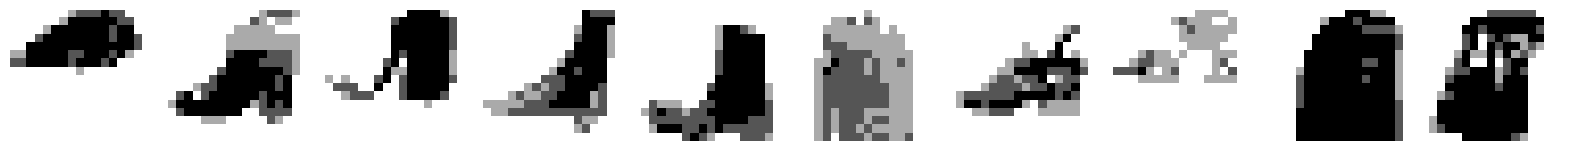

469/469 [==============================] - 21s 45ms/step - loss: 0.3285
Epoch 86/150
466/469 [============================>.] - ETA: 0s - loss: 0.3283
Saved to /content/images/generated_img_085.png


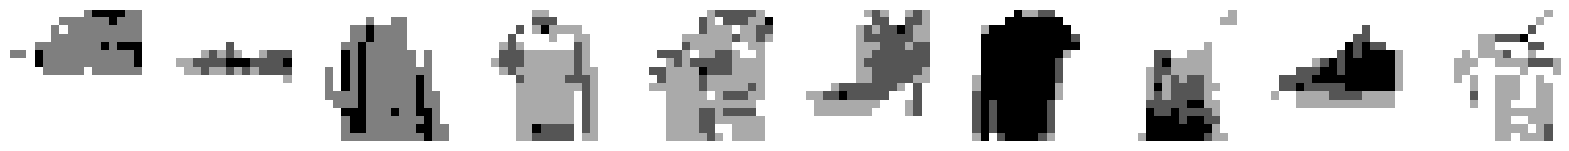

469/469 [==============================] - 20s 43ms/step - loss: 0.3283
Epoch 87/150
465/469 [============================>.] - ETA: 0s - loss: 0.3281
Saved to /content/images/generated_img_086.png


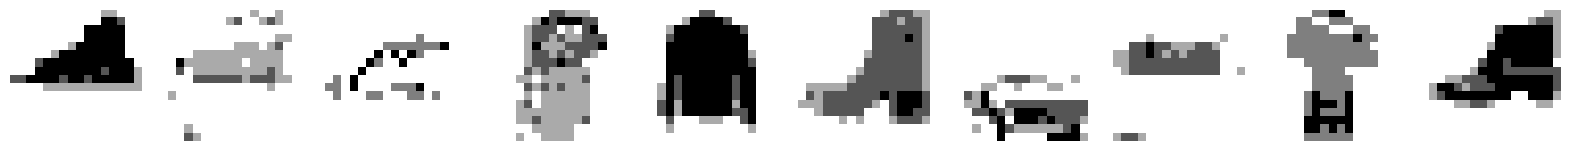

469/469 [==============================] - 20s 43ms/step - loss: 0.3281
Epoch 88/150
464/469 [============================>.] - ETA: 0s - loss: 0.3280
Saved to /content/images/generated_img_087.png


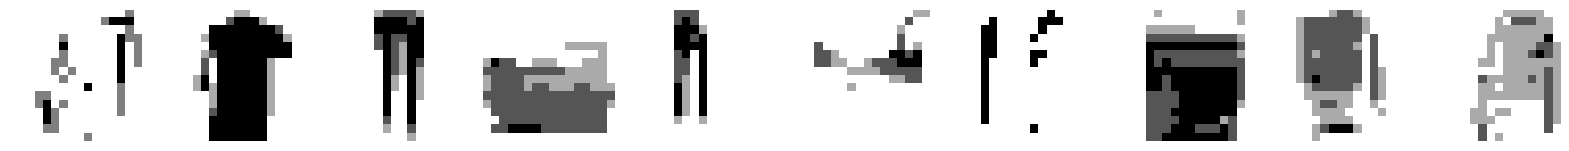

469/469 [==============================] - 20s 43ms/step - loss: 0.3280
Epoch 89/150
467/469 [============================>.] - ETA: 0s - loss: 0.3279
Saved to /content/images/generated_img_088.png


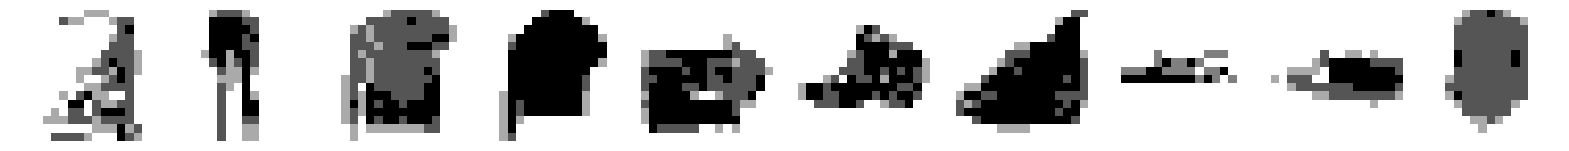

469/469 [==============================] - 20s 42ms/step - loss: 0.3279
Epoch 90/150
469/469 [==============================] - ETA: 0s - loss: 0.3278
Saved to /content/images/generated_img_089.png


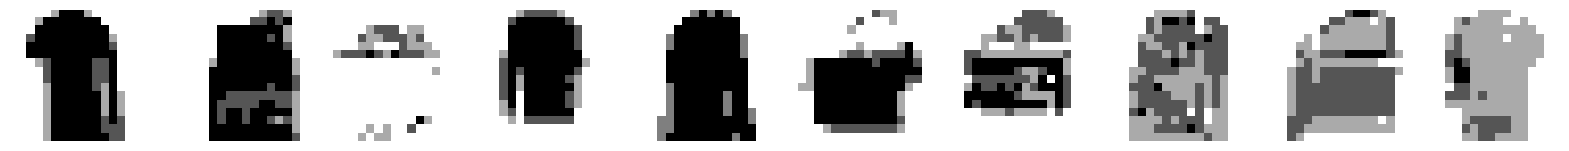

469/469 [==============================] - 21s 44ms/step - loss: 0.3278
Epoch 91/150
465/469 [============================>.] - ETA: 0s - loss: 0.3277
Saved to /content/images/generated_img_090.png


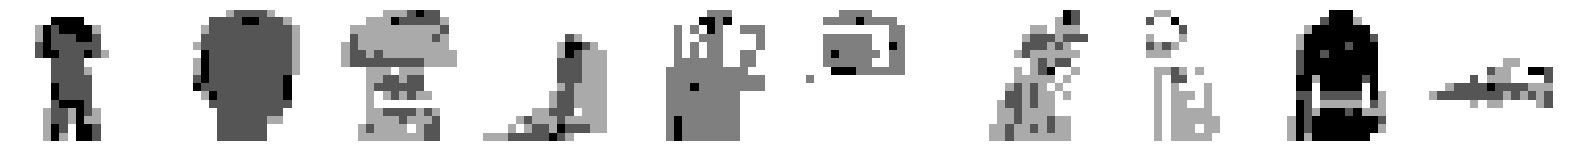

469/469 [==============================] - 20s 42ms/step - loss: 0.3277
Epoch 92/150
469/469 [==============================] - ETA: 0s - loss: 0.3275
Saved to /content/images/generated_img_091.png


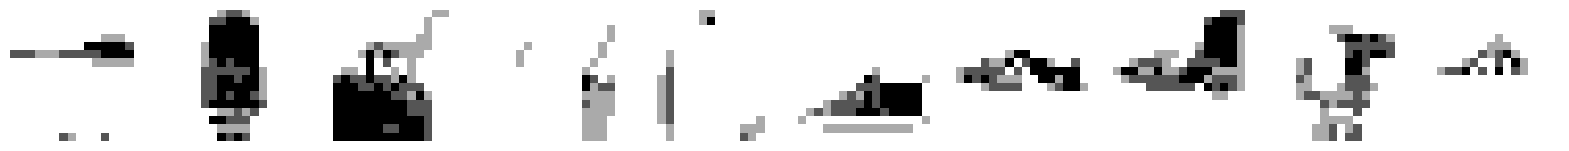

469/469 [==============================] - 19s 42ms/step - loss: 0.3275
Epoch 93/150
467/469 [============================>.] - ETA: 0s - loss: 0.3275
Saved to /content/images/generated_img_092.png


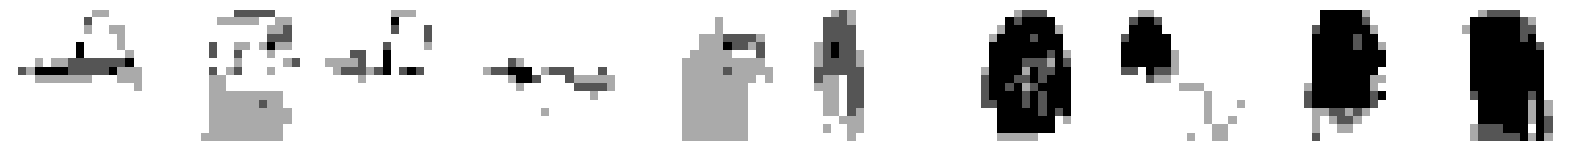

469/469 [==============================] - 21s 45ms/step - loss: 0.3276
Epoch 94/150
467/469 [============================>.] - ETA: 0s - loss: 0.3273
Saved to /content/images/generated_img_093.png


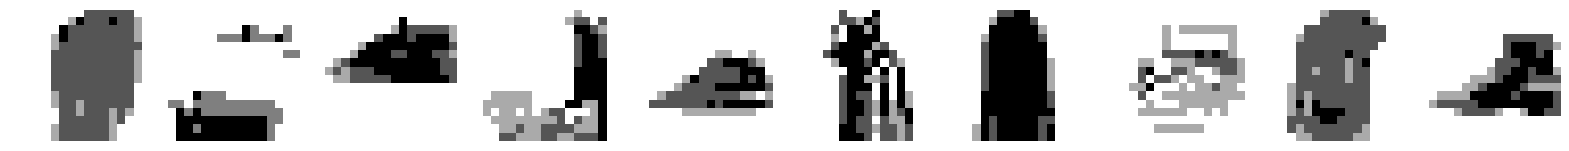

469/469 [==============================] - 20s 42ms/step - loss: 0.3272
Epoch 95/150
468/469 [============================>.] - ETA: 0s - loss: 0.3273
Saved to /content/images/generated_img_094.png


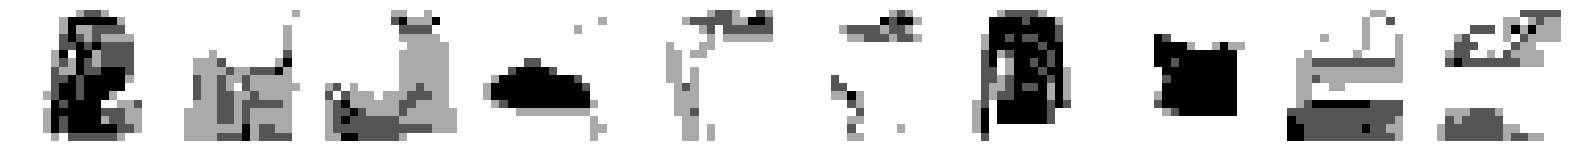

469/469 [==============================] - 20s 43ms/step - loss: 0.3273
Epoch 96/150
465/469 [============================>.] - ETA: 0s - loss: 0.3272
Saved to /content/images/generated_img_095.png


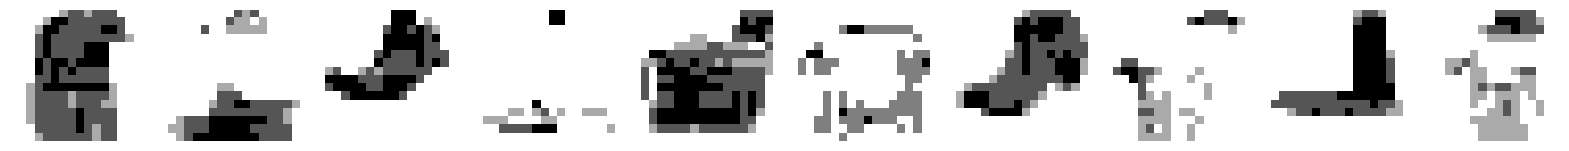

469/469 [==============================] - 20s 43ms/step - loss: 0.3272
Epoch 97/150
467/469 [============================>.] - ETA: 0s - loss: 0.3271
Saved to /content/images/generated_img_096.png


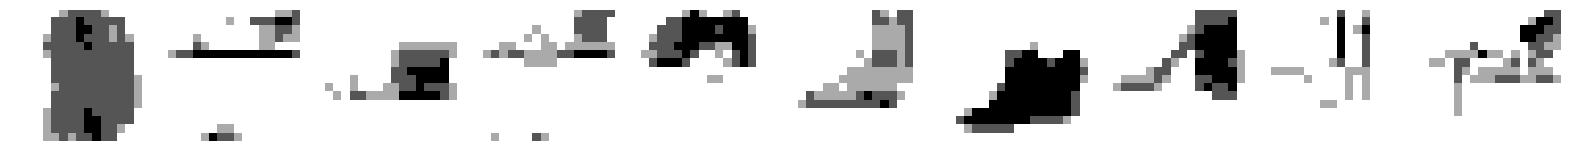

469/469 [==============================] - 20s 42ms/step - loss: 0.3270
Epoch 98/150
468/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to /content/images/generated_img_097.png


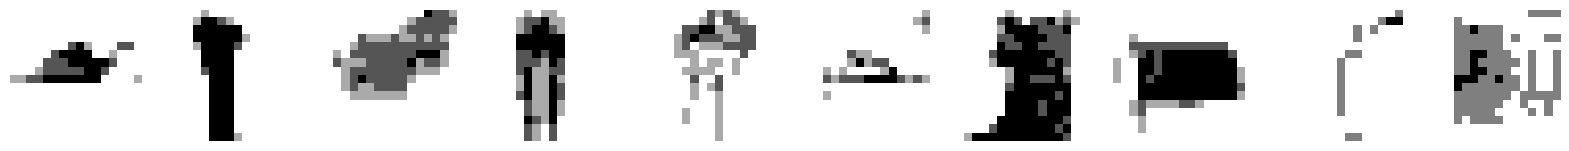

469/469 [==============================] - 21s 44ms/step - loss: 0.3269
Epoch 99/150
464/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to /content/images/generated_img_098.png


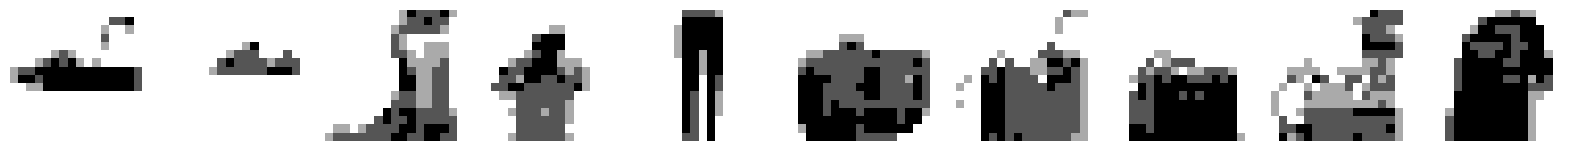

469/469 [==============================] - 20s 42ms/step - loss: 0.3268
Epoch 100/150
465/469 [============================>.] - ETA: 0s - loss: 0.3267
Saved to /content/images/generated_img_099.png


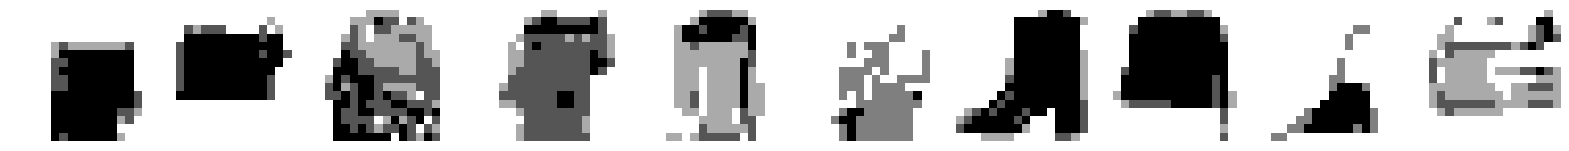

469/469 [==============================] - 20s 43ms/step - loss: 0.3267
Epoch 101/150
466/469 [============================>.] - ETA: 0s - loss: 0.3267
Saved to /content/images/generated_img_100.png


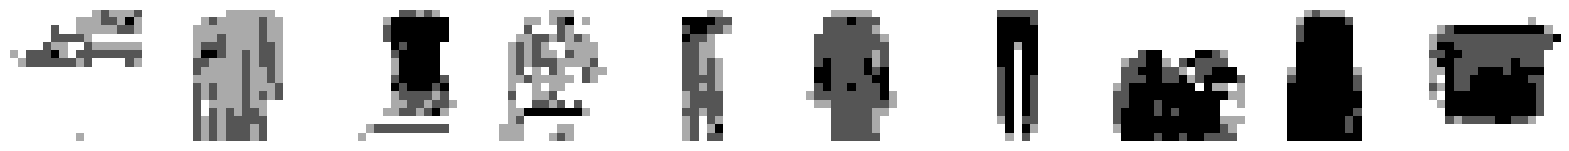

469/469 [==============================] - 21s 44ms/step - loss: 0.3267
Epoch 102/150
466/469 [============================>.] - ETA: 0s - loss: 0.3266
Saved to /content/images/generated_img_101.png


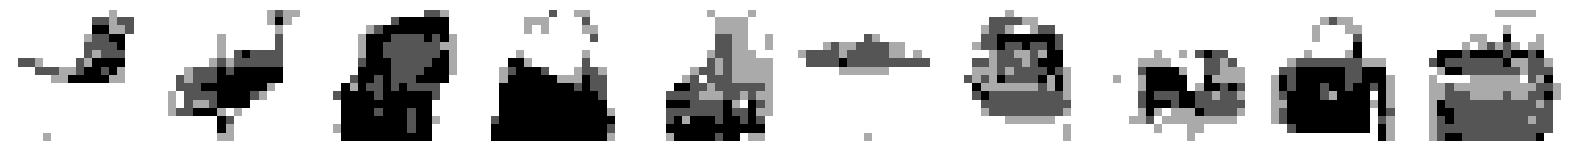

469/469 [==============================] - 20s 42ms/step - loss: 0.3267
Epoch 103/150
465/469 [============================>.] - ETA: 0s - loss: 0.3265
Saved to /content/images/generated_img_102.png


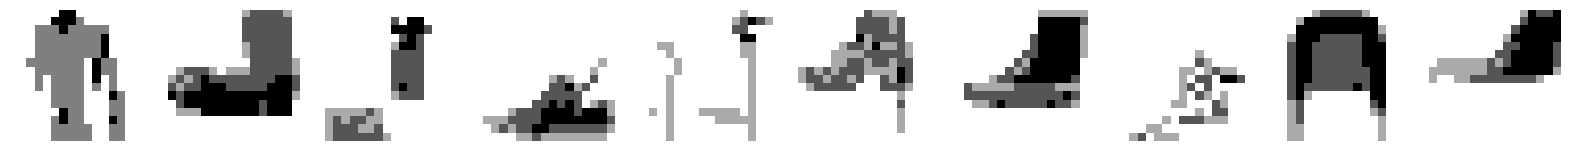

469/469 [==============================] - 21s 44ms/step - loss: 0.3265
Epoch 104/150
467/469 [============================>.] - ETA: 0s - loss: 0.3263
Saved to /content/images/generated_img_103.png


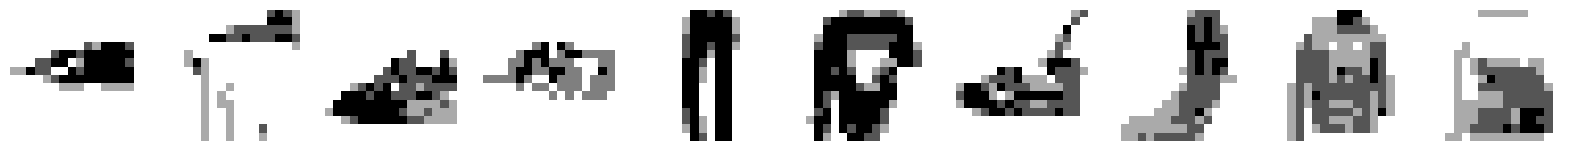

469/469 [==============================] - 20s 43ms/step - loss: 0.3264
Epoch 105/150
468/469 [============================>.] - ETA: 0s - loss: 0.3264
Saved to /content/images/generated_img_104.png


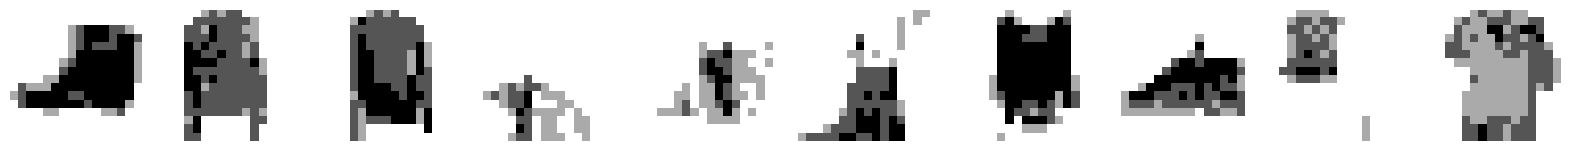

469/469 [==============================] - 20s 42ms/step - loss: 0.3263
Epoch 106/150
467/469 [============================>.] - ETA: 0s - loss: 0.3262
Saved to /content/images/generated_img_105.png


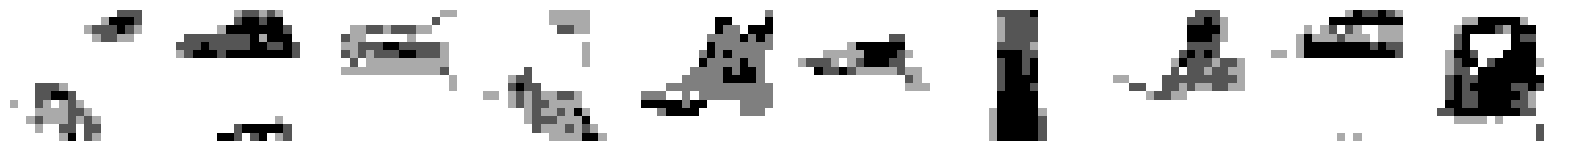

469/469 [==============================] - 21s 45ms/step - loss: 0.3262
Epoch 107/150
468/469 [============================>.] - ETA: 0s - loss: 0.3261
Saved to /content/images/generated_img_106.png


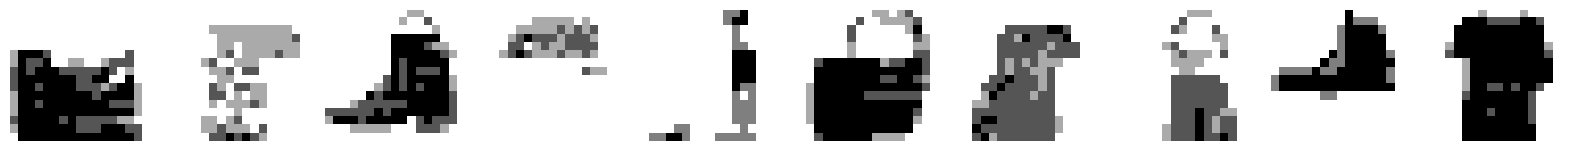

469/469 [==============================] - 20s 43ms/step - loss: 0.3261
Epoch 108/150
469/469 [==============================] - ETA: 0s - loss: 0.3260
Saved to /content/images/generated_img_107.png


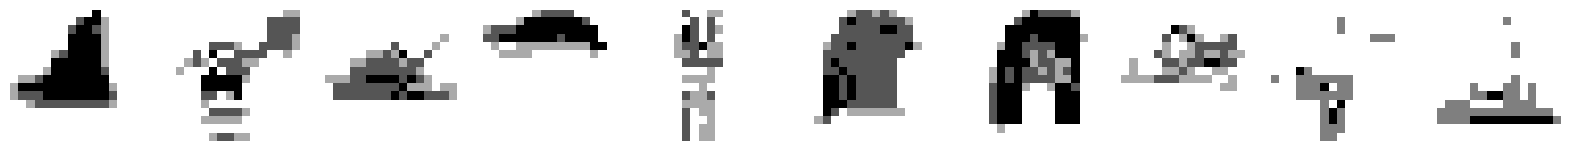

469/469 [==============================] - 20s 43ms/step - loss: 0.3260
Epoch 109/150
467/469 [============================>.] - ETA: 0s - loss: 0.3258
Saved to /content/images/generated_img_108.png


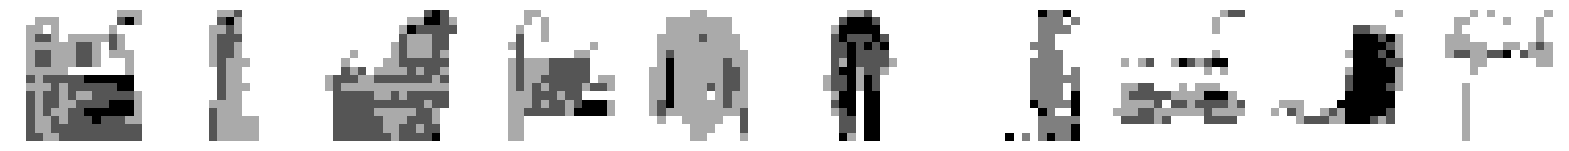

469/469 [==============================] - 21s 45ms/step - loss: 0.3259
Epoch 110/150
467/469 [============================>.] - ETA: 0s - loss: 0.3259
Saved to /content/images/generated_img_109.png


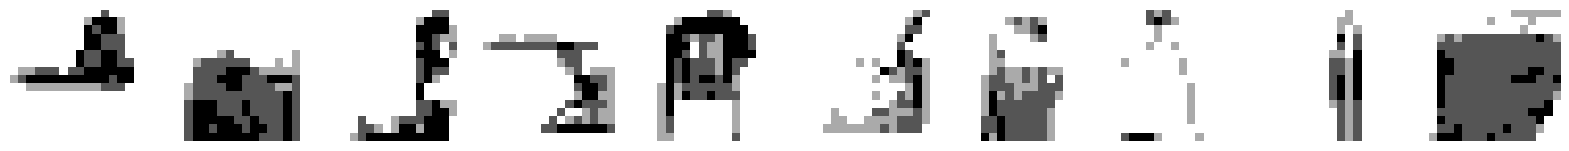

469/469 [==============================] - 19s 42ms/step - loss: 0.3259
Epoch 111/150
467/469 [============================>.] - ETA: 0s - loss: 0.3257
Saved to /content/images/generated_img_110.png


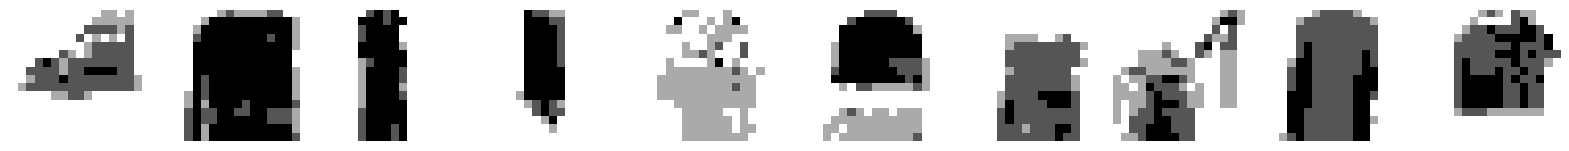

469/469 [==============================] - 21s 45ms/step - loss: 0.3257
Epoch 112/150
469/469 [==============================] - ETA: 0s - loss: 0.3256
Saved to /content/images/generated_img_111.png


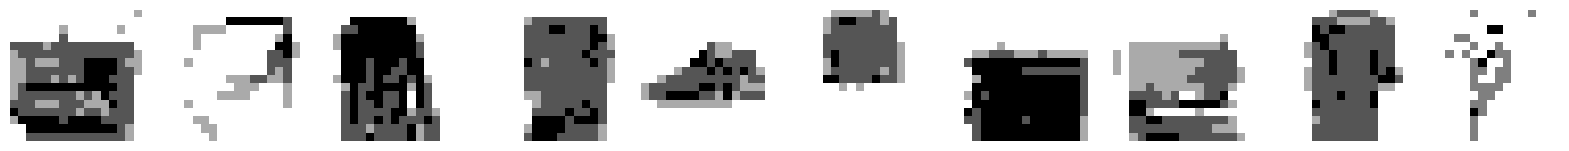

469/469 [==============================] - 20s 43ms/step - loss: 0.3256
Epoch 113/150
466/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to /content/images/generated_img_112.png


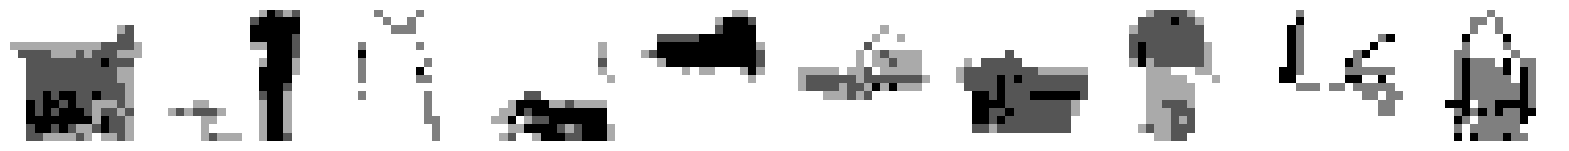

469/469 [==============================] - 20s 43ms/step - loss: 0.3257
Epoch 114/150
468/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to /content/images/generated_img_113.png


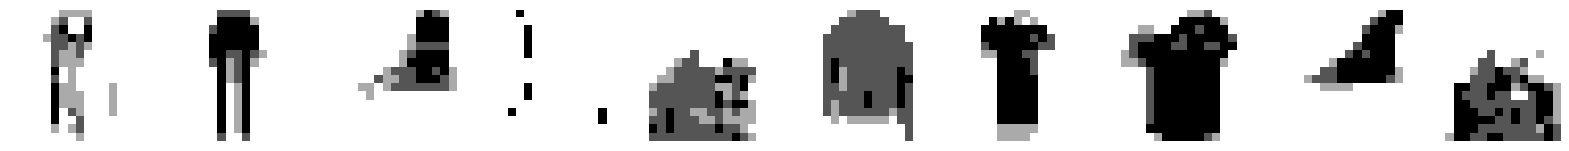

469/469 [==============================] - 21s 44ms/step - loss: 0.3255
Epoch 115/150
465/469 [============================>.] - ETA: 0s - loss: 0.3253
Saved to /content/images/generated_img_114.png


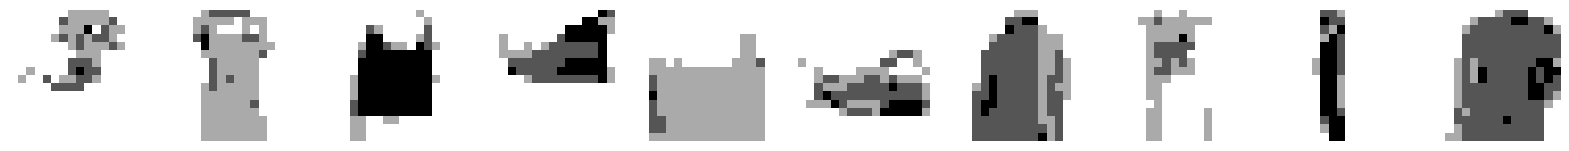

469/469 [==============================] - 19s 41ms/step - loss: 0.3254
Epoch 116/150
464/469 [============================>.] - ETA: 0s - loss: 0.3253
Saved to /content/images/generated_img_115.png


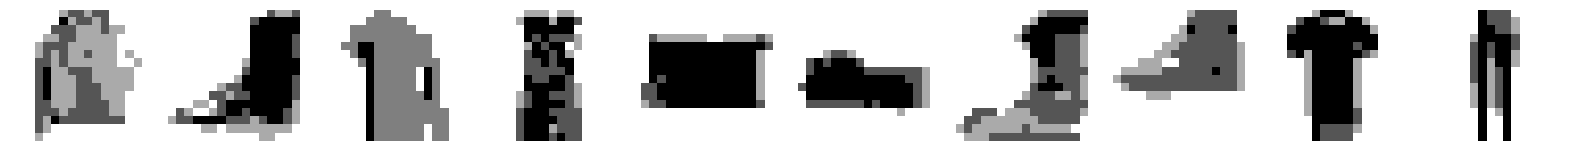

469/469 [==============================] - 21s 45ms/step - loss: 0.3253
Epoch 117/150
465/469 [============================>.] - ETA: 0s - loss: 0.3251
Saved to /content/images/generated_img_116.png


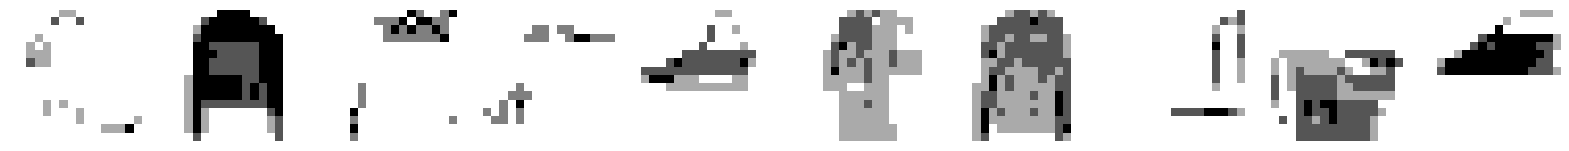

469/469 [==============================] - 20s 43ms/step - loss: 0.3251
Epoch 118/150
466/469 [============================>.] - ETA: 0s - loss: 0.3251
Saved to /content/images/generated_img_117.png


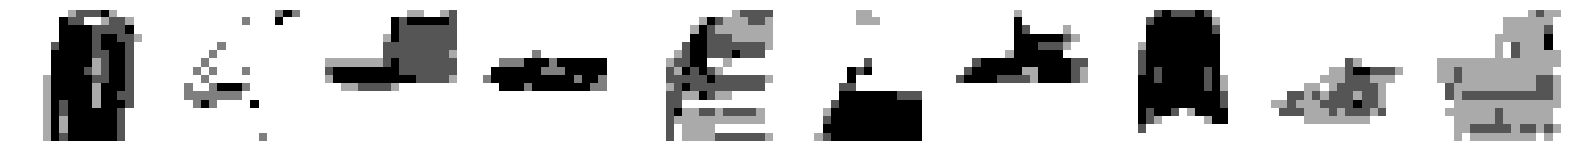

469/469 [==============================] - 19s 41ms/step - loss: 0.3251
Epoch 119/150
465/469 [============================>.] - ETA: 0s - loss: 0.3252
Saved to /content/images/generated_img_118.png


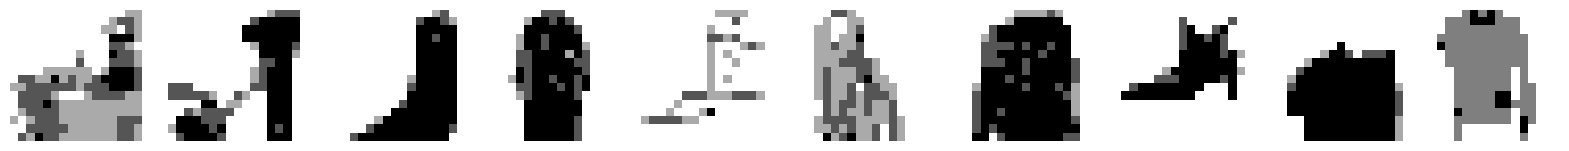

469/469 [==============================] - 21s 44ms/step - loss: 0.3252
Epoch 120/150
465/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to /content/images/generated_img_119.png


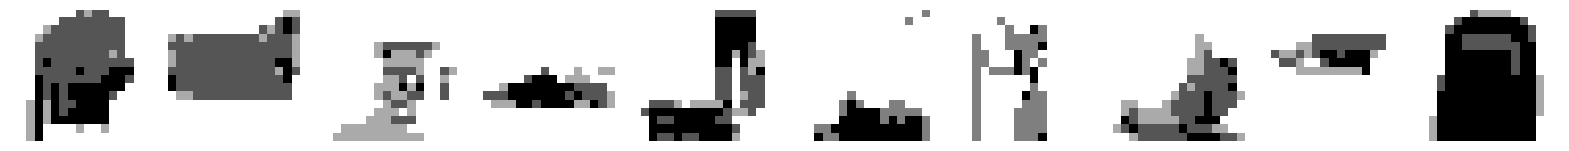

469/469 [==============================] - 20s 42ms/step - loss: 0.3250
Epoch 121/150
466/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to /content/images/generated_img_120.png


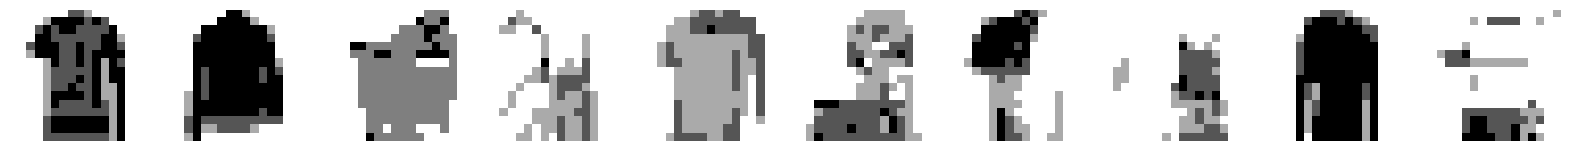

469/469 [==============================] - 20s 43ms/step - loss: 0.3250
Epoch 122/150
465/469 [============================>.] - ETA: 0s - loss: 0.3248
Saved to /content/images/generated_img_121.png


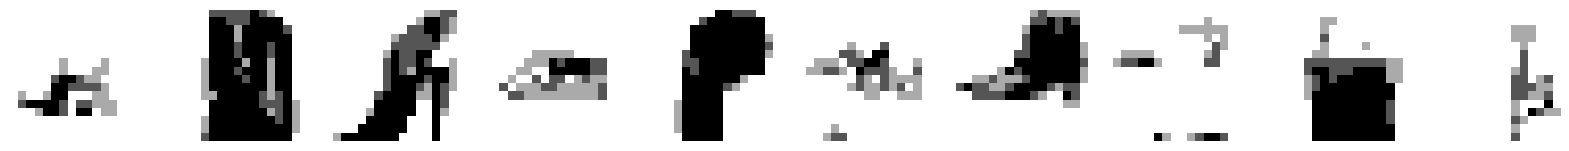

469/469 [==============================] - 21s 44ms/step - loss: 0.3248
Epoch 123/150
466/469 [============================>.] - ETA: 0s - loss: 0.3249
Saved to /content/images/generated_img_122.png


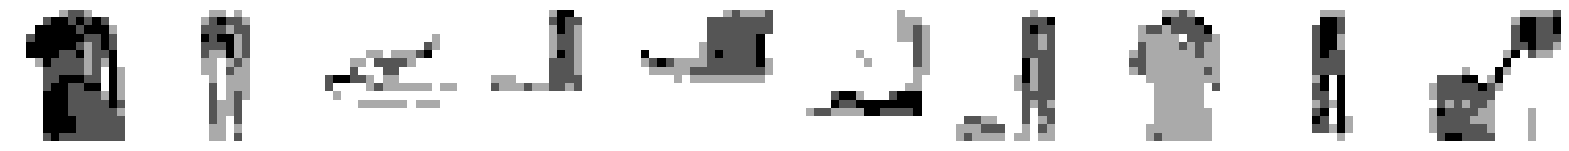

469/469 [==============================] - 20s 42ms/step - loss: 0.3249
Epoch 124/150
468/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to /content/images/generated_img_123.png


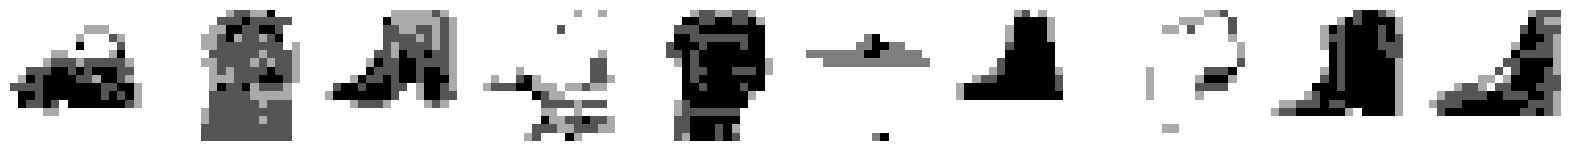

469/469 [==============================] - 21s 44ms/step - loss: 0.3246
Epoch 125/150
466/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to /content/images/generated_img_124.png


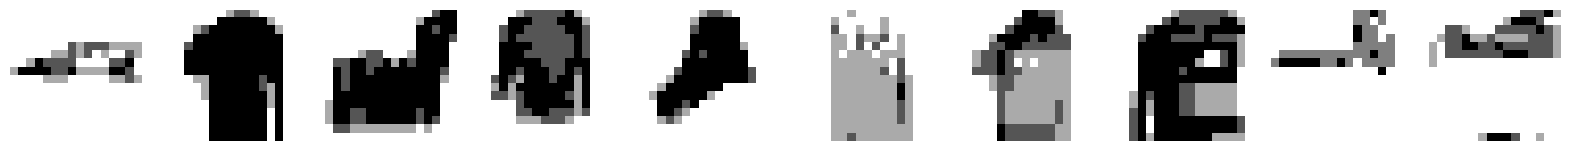

469/469 [==============================] - 20s 42ms/step - loss: 0.3246
Epoch 126/150
468/469 [============================>.] - ETA: 0s - loss: 0.3245
Saved to /content/images/generated_img_125.png


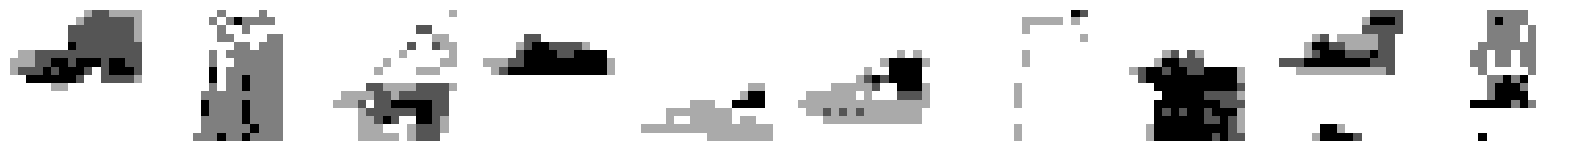

469/469 [==============================] - 20s 42ms/step - loss: 0.3245
Epoch 127/150
468/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to /content/images/generated_img_126.png


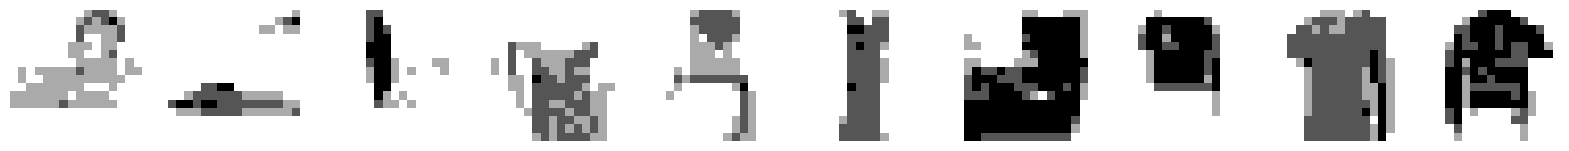

469/469 [==============================] - 21s 44ms/step - loss: 0.3245
Epoch 128/150
466/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to /content/images/generated_img_127.png


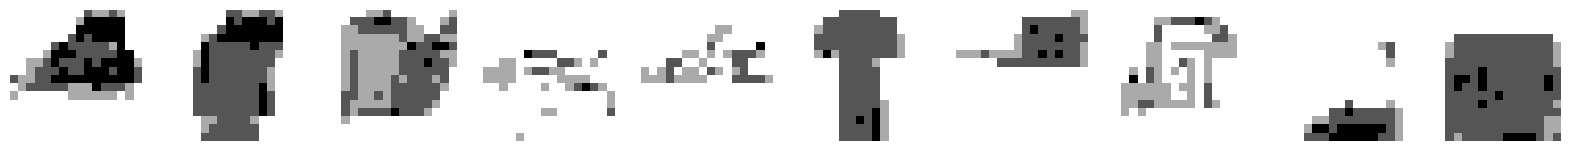

469/469 [==============================] - 20s 42ms/step - loss: 0.3244
Epoch 129/150
468/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to /content/images/generated_img_128.png


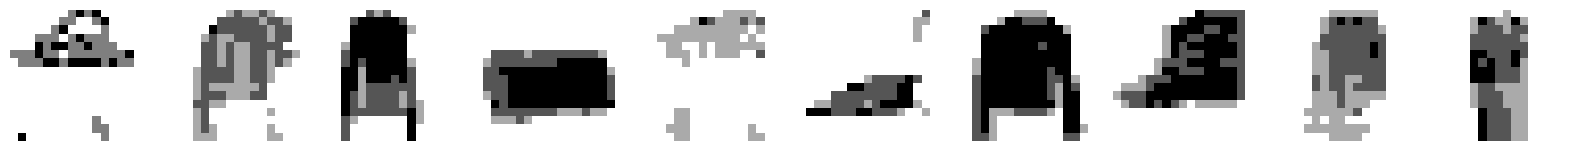

469/469 [==============================] - 21s 44ms/step - loss: 0.3243
Epoch 130/150
466/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to /content/images/generated_img_129.png


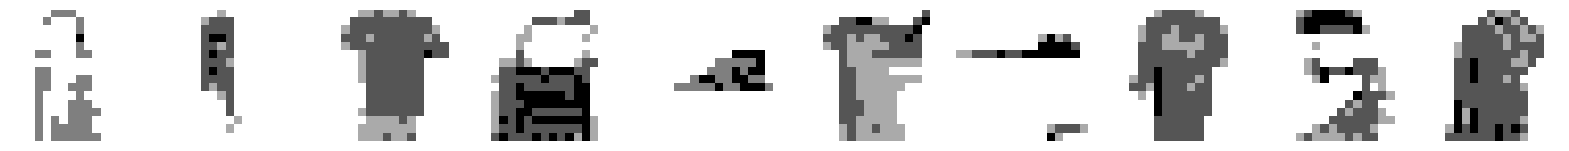

469/469 [==============================] - 20s 42ms/step - loss: 0.3243
Epoch 131/150
466/469 [============================>.] - ETA: 0s - loss: 0.3240
Saved to /content/images/generated_img_130.png


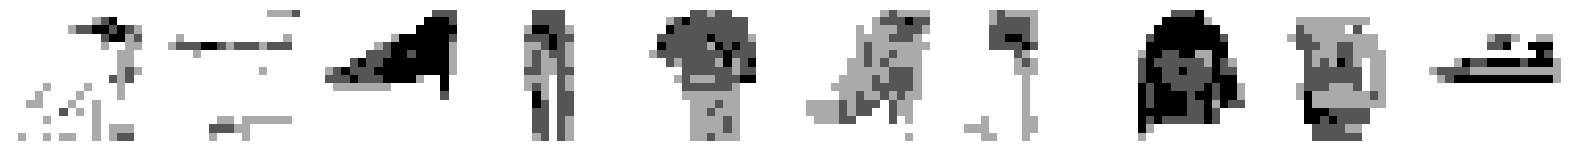

469/469 [==============================] - 20s 42ms/step - loss: 0.3241
Epoch 132/150
466/469 [============================>.] - ETA: 0s - loss: 0.3243
Saved to /content/images/generated_img_131.png


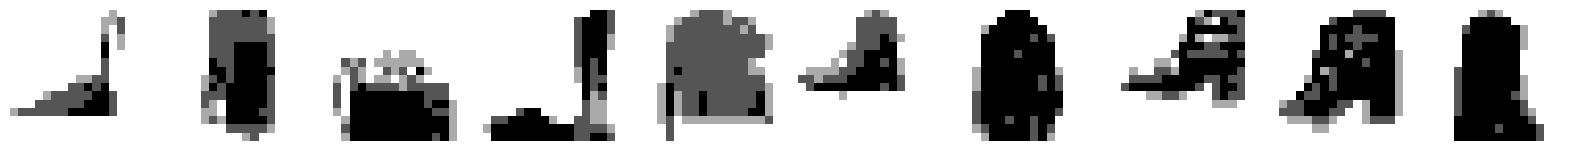

469/469 [==============================] - 21s 44ms/step - loss: 0.3242
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3240
Saved to /content/images/generated_img_132.png


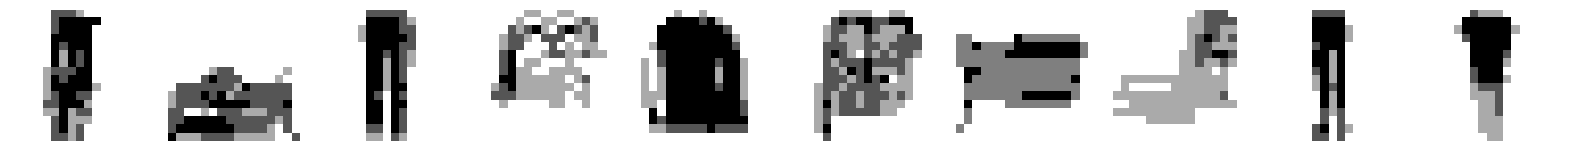

469/469 [==============================] - 20s 42ms/step - loss: 0.3240
Epoch 134/150
465/469 [============================>.] - ETA: 0s - loss: 0.3241
Saved to /content/images/generated_img_133.png


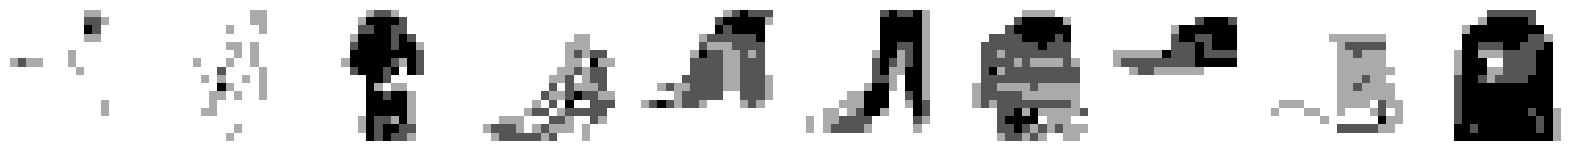

469/469 [==============================] - 20s 42ms/step - loss: 0.3241
Epoch 135/150
468/469 [============================>.] - ETA: 0s - loss: 0.3240
Saved to /content/images/generated_img_134.png


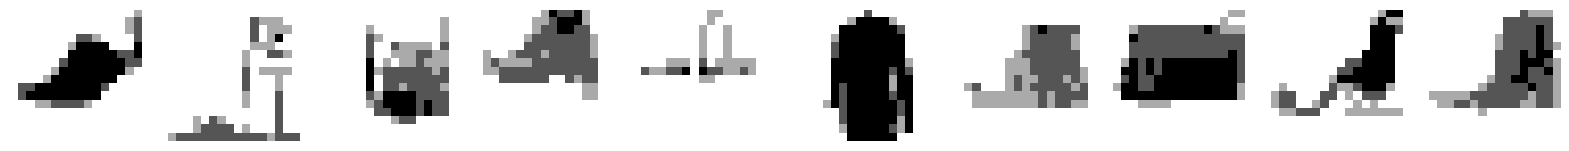

469/469 [==============================] - 21s 44ms/step - loss: 0.3239
Epoch 136/150
467/469 [============================>.] - ETA: 0s - loss: 0.3236
Saved to /content/images/generated_img_135.png


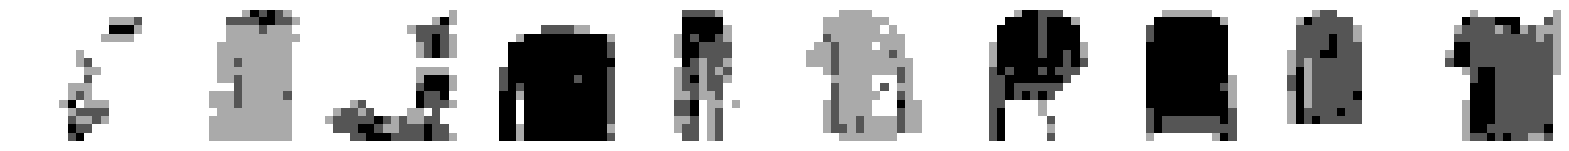

469/469 [==============================] - 19s 41ms/step - loss: 0.3236
Epoch 137/150
466/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to /content/images/generated_img_136.png


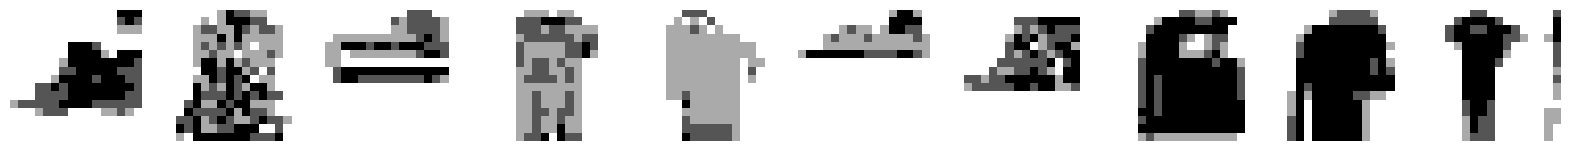

469/469 [==============================] - 21s 45ms/step - loss: 0.3238
Epoch 138/150
468/469 [============================>.] - ETA: 0s - loss: 0.3237
Saved to /content/images/generated_img_137.png


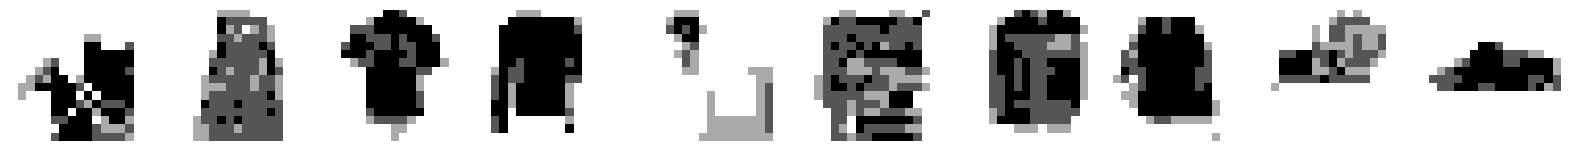

469/469 [==============================] - 20s 42ms/step - loss: 0.3237
Epoch 139/150
466/469 [============================>.] - ETA: 0s - loss: 0.3236
Saved to /content/images/generated_img_138.png


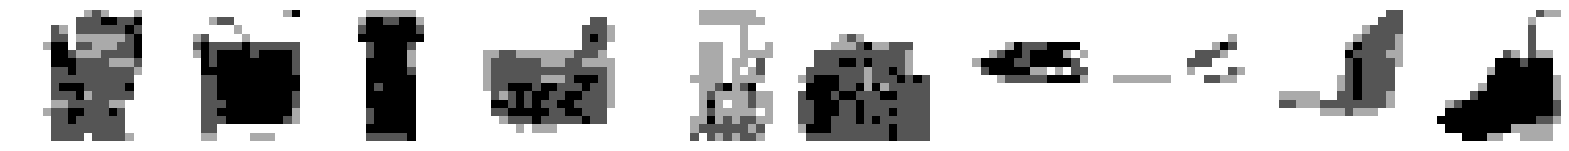

469/469 [==============================] - 20s 43ms/step - loss: 0.3236
Epoch 140/150
467/469 [============================>.] - ETA: 0s - loss: 0.3236
Saved to /content/images/generated_img_139.png


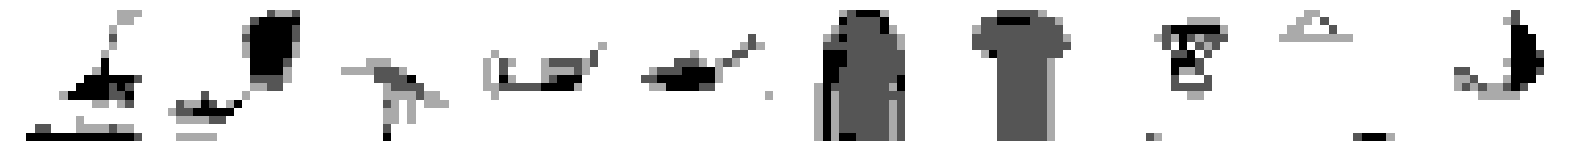

469/469 [==============================] - 20s 43ms/step - loss: 0.3236
Epoch 141/150
465/469 [============================>.] - ETA: 0s - loss: 0.3234
Saved to /content/images/generated_img_140.png


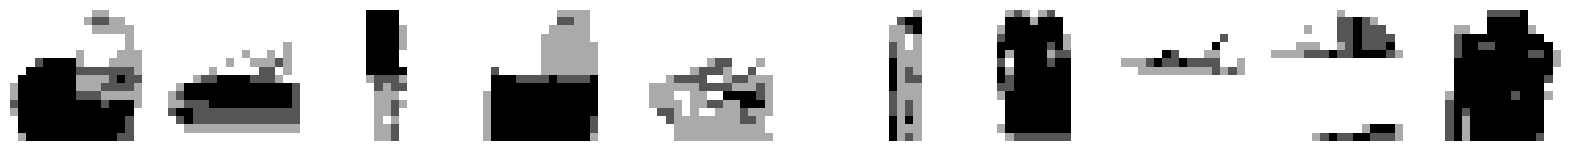

469/469 [==============================] - 20s 42ms/step - loss: 0.3234
Epoch 142/150
467/469 [============================>.] - ETA: 0s - loss: 0.3234
Saved to /content/images/generated_img_141.png


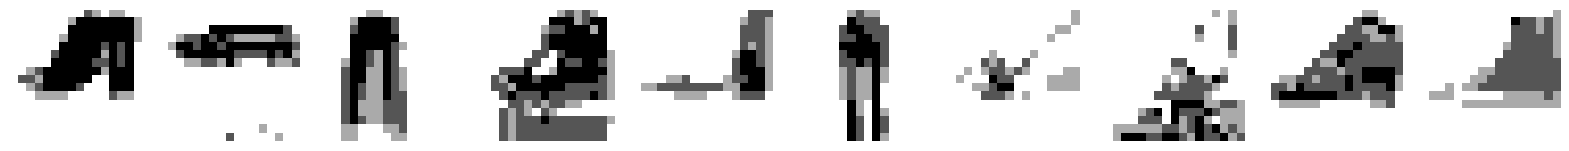

469/469 [==============================] - 21s 44ms/step - loss: 0.3234
Epoch 143/150
467/469 [============================>.] - ETA: 0s - loss: 0.3233
Saved to /content/images/generated_img_142.png


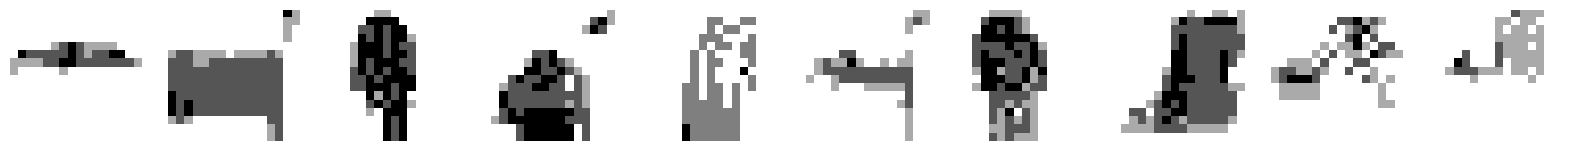

469/469 [==============================] - 20s 42ms/step - loss: 0.3233
Epoch 144/150
465/469 [============================>.] - ETA: 0s - loss: 0.3231
Saved to /content/images/generated_img_143.png


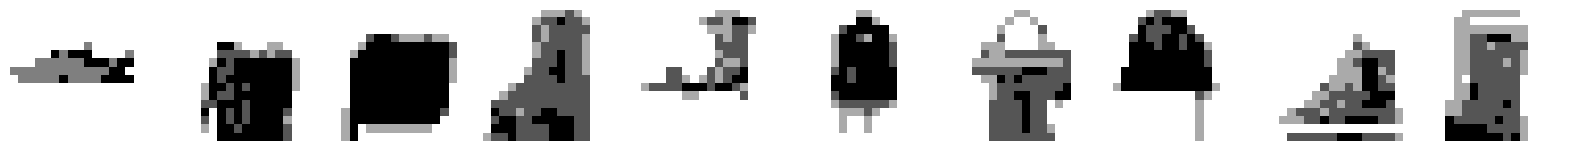

469/469 [==============================] - 19s 41ms/step - loss: 0.3231
Epoch 145/150
467/469 [============================>.] - ETA: 0s - loss: 0.3232
Saved to /content/images/generated_img_144.png


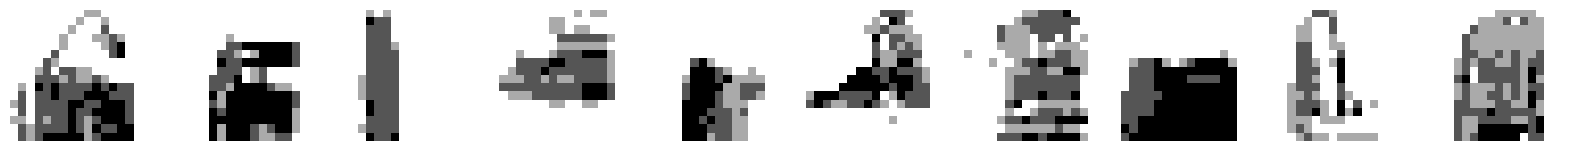

469/469 [==============================] - 21s 45ms/step - loss: 0.3232
Epoch 146/150
468/469 [============================>.] - ETA: 0s - loss: 0.3231
Saved to /content/images/generated_img_145.png


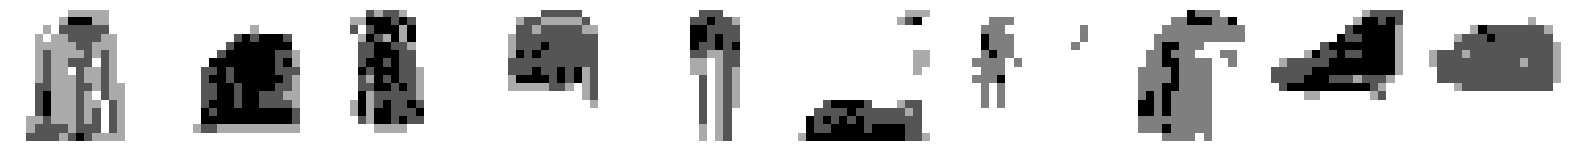

469/469 [==============================] - 20s 42ms/step - loss: 0.3231
Epoch 147/150
468/469 [============================>.] - ETA: 0s - loss: 0.3231
Saved to /content/images/generated_img_146.png


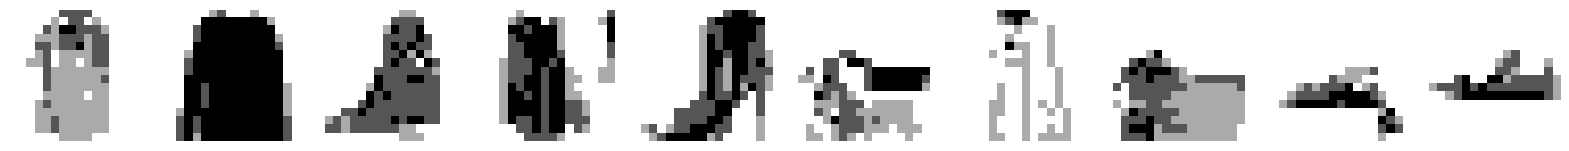

469/469 [==============================] - 20s 43ms/step - loss: 0.3231
Epoch 148/150
467/469 [============================>.] - ETA: 0s - loss: 0.3230
Saved to /content/images/generated_img_147.png


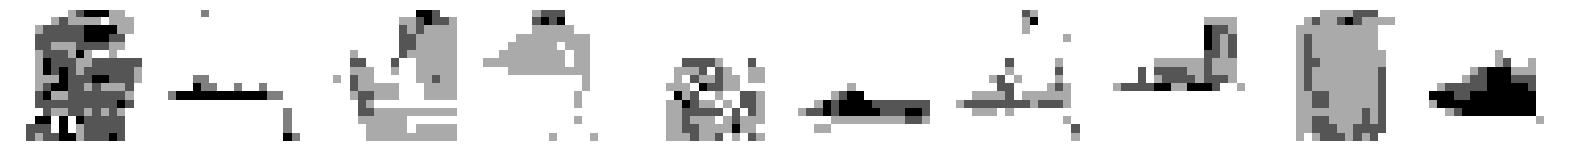

469/469 [==============================] - 21s 44ms/step - loss: 0.3229
Epoch 149/150
467/469 [============================>.] - ETA: 0s - loss: 0.3229
Saved to /content/images/generated_img_148.png


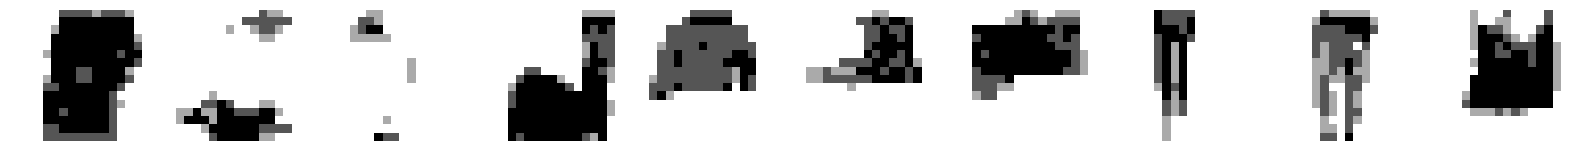

469/469 [==============================] - 20s 42ms/step - loss: 0.3230
Epoch 150/150
466/469 [============================>.] - ETA: 0s - loss: 0.3230
Saved to /content/images/generated_img_149.png


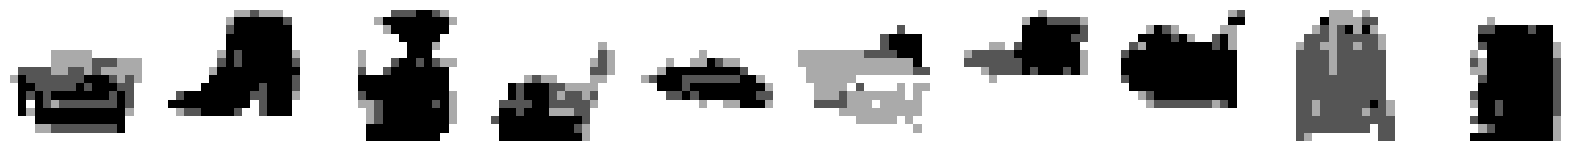

469/469 [==============================] - 21s 44ms/step - loss: 0.3230


In [ ]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)